<img src="cetelem1b.jpg" />

# Imports

In [1]:
# Math et données
import numpy as np
# import scipy
# from scipy.stats import zscore
import pandas as pd
from datetime import date
import itertools

# Librairies graphiques
import matplotlib.pyplot as plt
import seaborn as sns

import copy

c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Pre-processing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Feature selection
from sklearn.model_selection import GridSearchCV, KFold

# ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
# from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, SVMSMOTE, ADASYN

In [3]:
import joblib

In [4]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [5]:
import re

In [6]:
# Modules perso
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [7]:
import DisplotData, DisplotML, PwePwocess, Funktiuns
from DisplotData import bcolors
import MLstuff

In [8]:
pd.set_option("display.max_columns", 150) # None

# Noyau Kaggle

## Fonctions

### Preprocessing

In [9]:
# Display/plot feature importance
def display_importances(feature_importance_df_, n_feat=40, algo_name=''):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:n_feat].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    result = best_features[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    plt.figure()
    # sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    sns.barplot(x="importance", y="feature", data=best_features, order=result)

    plt.title(f'{algo_name} features')
    plt.tight_layout()
    plt.savefig(f'{algo_name}_importances.png')

In [10]:
def keep_selected_cols(df, selected_features, table_name=''):
    if not selected_features is None:
        kept_cols = selected_features.loc[selected_features['Table'].str.startswith(
            table_name), 'Row'].values
        efc_kept_cols = [c for c in df.columns if c in kept_cols]
        df = df[efc_kept_cols]
    return df


def rename_non_relaxable_cat_cols(df, selected_features, cat_cols, suffix='_NR', sep='__'):
    #     print(f"df.columns AVANT = {df.columns}")
    new_cat_cols = []
    if not selected_features is None:
        non_relaxable_cols = selected_features.loc[selected_features['Non-relaxable']==1, 'Row'].values
        # print(f"non_relaxable_cols = {non_relaxable_cols}")
        # print(f"cat_cols = {cat_cols}")
        for col_enc in cat_cols:
            # print(f"col_enc = {col_enc}")
            col = col_enc.split(sep)[0]
            # print(f"col = {col}")
            if col in non_relaxable_cols: # and col_enc in df.columns
                col_enc2 = col_enc+suffix
                # print(f"col_enc2 = {col_enc2}")
                new_cat_cols.append(col_enc2)
                df.rename(columns={col_enc: col_enc2}, inplace=True)
            else:
                new_cat_cols.append(col_enc)
    # print(f"df.columns APRES = {df.columns}")
    return df, new_cat_cols

def rename_non_relaxable_num_cols(df, selected_features, suffix='_NR', sep='#'):
    new_num_cols = []
    num_cols = [col for col in df.columns if df[col].dtype != 'object']
    if not selected_features is None:
        non_relaxable_cols = selected_features.loc[selected_features['Non-relaxable']==1, 'Row'].values
        # print(f"non_relaxable_cols = {non_relaxable_cols}")
        # print(f"num_cols = {num_cols}")
        for col_agg in num_cols:
            # print(f"col_agg = {col_agg}")
            col = col_agg.split(sep)[0]
            for prefix in ['BURO_', 'ACTIVE_', 'CLOSED_', 'PREV_', 'APPROVED_', 'REFUSED_', 'POS_', 'INSTAL_', 'CC_']:
                col = col.replace(prefix, '')
            # print(f"col = {col}")
            if col in non_relaxable_cols: # and col_agg in df.columns
                col_agg2 = col_agg+suffix
                # print(f"col2 = {col2}")
                new_num_cols.append(col_agg2)
                df.rename(columns={col_agg: col_agg2}, inplace=True)
            else:
                new_num_cols.append(col_agg)
    # print(f"df.columns APRES = {df.columns}")
    return df, new_num_cols
    

In [11]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True, prefix_sep='_'):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, prefix_sep=prefix_sep)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(selected_features=None, num_rows=None, nan_as_category=False):
    # Read data and merge
    # df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
    df = df_application_train[0:num_rows]
    # test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
    test_df = df_application_test[0:num_rows]
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Keep only wished cols, if they are specified
    df = keep_selected_cols(df, selected_features, table_name='application_{train|test}.csv')    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']: # comme étape du ColumnTransformer
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category, prefix_sep='__')
    
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    df, cat_cols = rename_non_relaxable_cat_cols(df, selected_features, cat_cols)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    df, num_cols = rename_non_relaxable_num_cols(df, selected_features)
    del test_df
    gc.collect()
    return df, cat_cols

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(selected_features=None, num_rows=None, nan_as_category=True):
    # bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bureau = df_bureau # global
    # bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb = df_bureau_balance # global
    # Keep only wished cols, if they are specified
    bureau = keep_selected_cols(bureau, selected_features, table_name='bureau.csv')
    bb = keep_selected_cols(bb, selected_features, table_name='bureau_balance.csv')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category, prefix_sep='__')
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category, prefix_sep='__')    
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    bb, bb_cat = rename_non_relaxable_cat_cols(bb, selected_features, bb_cat)
    bureau, bureau_cat = rename_non_relaxable_cat_cols(bureau, selected_features, bureau_cat)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {}
    # Numerical
    if not selected_features is None:
        bb_num = list(set(bb.columns)-set(bb_cat)-set(['SK_ID_CURR', 'SK_ID_BUREAU']))
        # ops = selected_features.loc[selected_features['Row']=='MONTHS_BALANCE', 'Operations'].values[0] # TODO : fonction
        # bb_aggregations = {'MONTHS_BALANCE': ops} y sera !
        for col in bb_num:
            ops = selected_features.loc[(selected_features['Table'].str.startswith('bureau')) & (selected_features['Row']==col), 'Operations'].values
            # print(col, ops) # DEBUG
            if len(ops): 
                bb_aggregations[col] = ops[0] # TODO : attention plusieurs features ont le même nom
    else:
        bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    # Categorical
    for col in bb_cat: # TODO: récupérer les nouvelles colonnes _NR
        bb_aggregations[col] = ['mean'] # TODO : récupérer les opérations souhaitées pour la feature racine

    # print(bb_aggregations)
    # print(f"bb = {bb}") # DEBUG

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    # print(bb_aggregations) # DEBUG
    bb_agg.columns = pd.Index([e[0] + "#" + e[1].upper() for e in bb_agg.columns.tolist()])
    # *** ICI on a modifié le nom des colonnes, donc cat_cols doit devenir cette nouvelle liste
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    # print(f"bureau.columns 1 = {bureau.columns}") # DEBUG
    
    # Bureau and bureau_balance numeric features
    if not selected_features is None:
        bb_num = list(set(bureau.columns)-set(bureau_cat)-set(bb_cat)-set(['SK_ID_CURR', 'SK_ID_BUREAU']))
        num_aggregations = {}
        for col in bb_num:
            ops = selected_features.loc[(selected_features['Table'].str.startswith('bureau')) & (selected_features['Row']==col), 'Operations'].values
            # print(col, ops) # DEBUG
            if len(ops): 
                num_aggregations[col] = ops[0]
    
    else:
        num_aggregations = {
            'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
            'DAYS_CREDIT_UPDATE': ['mean'],
            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
            'AMT_CREDIT_MAX_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
            'AMT_ANNUITY': ['max', 'mean'],
            'CNT_CREDIT_PROLONG': ['sum'],
            'MONTHS_BALANCE_MIN': ['min'],
            'MONTHS_BALANCE_MAX': ['max'],
            'MONTHS_BALANCE_SIZE': ['mean', 'sum']
        }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "#MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "#" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE__Active_NR'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "#" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE__Closed_NR'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "#" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    bureau_agg, num_cols = rename_non_relaxable_num_cols(bureau_agg, selected_features)
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg, bb_cat, bureau_cat

# Preprocess previous_applications.csv
def previous_applications(selected_features=None, num_rows=None, nan_as_category=True):
    # prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev = df_previous_application # global
    # Keep only wished cols, if they are specified
    prev = keep_selected_cols(prev, selected_features, table_name='previous_application.csv')
    prev, prev_cat_cols = one_hot_encoder(prev, nan_as_category= True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    prev, prev_cat_cols = rename_non_relaxable_cat_cols(prev, selected_features, prev_cat_cols)
    # Days 365.243 values -> nan
    if 'DAYS_FIRST_DRAWING' in prev.columns: prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    if 'DAYS_FIRST_DUE' in prev.columns: prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    if 'DAYS_LAST_DUE_1ST_VERSION' in prev.columns: prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    if 'DAYS_LAST_DUE' in prev.columns: prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    if 'DAYS_TERMINATION' in prev.columns: prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    if 'AMT_APPLICATION' in prev.columns and 'AMT_CREDIT' in prev.columns: 
        prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
        prev.loc[prev['APP_CREDIT_PERC']>1.e300] = 1. # CG
    # Previous applications numeric features
    # num_aggregations = {
    #     'AMT_ANNUITY': ['min', 'max', 'mean'],
    #     'AMT_APPLICATION': ['min', 'max', 'mean'],
    #     'AMT_CREDIT': ['min', 'max', 'mean'],
    #     'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    #     'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    #     'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    #     'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    #     'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    #     'DAYS_DECISION': ['min', 'max', 'mean'],
    #     'CNT_PAYMENT': ['mean', 'sum'],
    # }
    num_aggregations = {}
    if 'AMT_ANNUITY' in prev.columns: num_aggregations['AMT_ANNUITY'] = ['min', 'max', 'mean'] # TODO : fonction à partir du dico ci-dessus
    if 'AMT_APPLICATION' in prev.columns: num_aggregations['AMT_APPLICATION'] = ['min', 'max', 'mean']
    if 'AMT_CREDIT' in prev.columns: num_aggregations['AMT_CREDIT'] = ['min', 'max', 'mean']
    if 'APP_CREDIT_PERC' in prev.columns: num_aggregations['APP_CREDIT_PERC'] = ['min', 'max', 'mean', 'var']
    if 'AMT_DOWN_PAYMENT' in prev.columns: num_aggregations['AMT_DOWN_PAYMENT'] = ['min', 'max', 'mean']
    if 'AMT_GOODS_PRICE' in prev.columns: num_aggregations['AMT_GOODS_PRICE'] = ['min', 'max', 'mean']
    if 'HOUR_APPR_PROCESS_START' in prev.columns: num_aggregations['HOUR_APPR_PROCESS_START'] = ['min', 'max', 'mean']
    if 'RATE_DOWN_PAYMENT' in prev.columns: num_aggregations['RATE_DOWN_PAYMENT'] = ['min', 'max', 'mean']
    if 'DAYS_DECISION' in prev.columns: num_aggregations['DAYS_DECISION'] = ['min', 'max', 'mean']
    if 'CNT_PAYMENT' in prev.columns: num_aggregations['CNT_PAYMENT'] = ['mean', 'sum']
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in prev_cat_cols:
        cat_aggregations[cat] = ['mean'] # Donc le OneHot devient non-entier
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "#" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS__Approved_NR'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "#" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS__Refused_NR'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "#" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    prev_agg, num_cols = rename_non_relaxable_num_cols(prev_agg, selected_features)
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg, prev_cat_cols

# Preprocess POS_CASH_balance.csv
def pos_cash(selected_features=None, num_rows=None, nan_as_category=True):
    # pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos = df_POS_CASH_balance # global
    # Keep only wished cols, if they are specified
    pos = keep_selected_cols(pos, selected_features, table_name='POS_CASH_balance.csv')
    pos, pos_cat_cols = one_hot_encoder(pos, nan_as_category=True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    pos, pos_cat_cols = rename_non_relaxable_cat_cols(pos, selected_features, pos_cat_cols)

    # Features
    # aggregations = {
    #     'MONTHS_BALANCE': ['max', 'mean', 'size'],
    #     'SK_DPD': ['max', 'mean'],
    #     'SK_DPD_DEF': ['max', 'mean']
    # }
    aggregations = {}
    if 'MONTHS_BALANCE' in pos.columns: aggregations['MONTHS_BALANCE'] = ['max', 'mean', 'size']
    if 'SK_DPD' in pos.columns: aggregations['SK_DPD'] = ['max', 'mean']
    if 'SK_DPD_DEF' in pos.columns: aggregations['SK_DPD_DEF'] = ['max', 'mean']
    
    for cat in pos_cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "#" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT_NR'] = pos.groupby('SK_ID_CURR').size()
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    pos_agg, num_cols = rename_non_relaxable_num_cols(pos_agg, selected_features)
    del pos
    gc.collect()
    return pos_agg, pos_cat_cols
    
# Preprocess installments_payments.csv
def installments_payments(selected_features=None, num_rows=None, nan_as_category=True):
    # ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins = df_installments_payments # global
    # Keep only wished cols, if they are specified
    ins = keep_selected_cols(ins, selected_features, table_name='installments_payments.csv')
    ins, ins_cat_cols = one_hot_encoder(ins, nan_as_category=True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    ins, ins_cat_cols = rename_non_relaxable_cat_cols(ins, selected_features, ins_cat_cols)
    # Percentage and difference paid in each installment (amount paid and installment value)
    if 'AMT_PAYMENT' in ins.columns and 'AMT_INSTALMENT' in ins.columns: 
        ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
        ins.loc[ins['PAYMENT_PERC']>1.e300] = 1. # CG
        ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    if 'DAYS_ENTRY_PAYMENT' in ins.columns and 'DAYS_INSTALMENT' in ins.columns:
        ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
        ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    if 'DAYS_INSTALMENT' in ins.columns and 'DAYS_ENTRY_PAYMENT' in ins.columns: 
        ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
        ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    # aggregations = {
    #     'NUM_INSTALMENT_VERSION': ['nunique'],
    #     'DPD': ['max', 'mean', 'sum'],
    #     'DBD': ['max', 'mean', 'sum'],
    #     'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    #     'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    #     'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    #     'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    #     'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    # }
    aggregations = {}
    if 'NUM_INSTALMENT_VERSION' in ins.columns: aggregations['NUM_INSTALMENT_VERSION'] = ['nunique']
    if 'DPD' in ins.columns: aggregations['DPD'] = ['max', 'mean', 'sum']
    if 'DBD' in ins.columns: aggregations['DBD'] = ['max', 'mean', 'sum']
    if 'PAYMENT_PERC' in ins.columns: aggregations['PAYMENT_PERC'] = ['max', 'mean', 'sum', 'var']
    if 'PAYMENT_DIFF' in ins.columns: aggregations['PAYMENT_DIFF'] = ['max', 'mean', 'sum', 'var']
    if 'AMT_INSTALMENT' in ins.columns: aggregations['AMT_INSTALMENT'] = ['max', 'mean', 'sum']
    if 'AMT_PAYMENT' in ins.columns: aggregations['AMT_PAYMENT'] = ['min', 'max', 'mean', 'sum']
    if 'DAYS_ENTRY_PAYMENT' in ins.columns: aggregations['DAYS_ENTRY_PAYMENT'] = ['max', 'mean', 'sum']
    
    for cat in ins_cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "#" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT_NR'] = ins.groupby('SK_ID_CURR').size()
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    ins_agg, num_cols = rename_non_relaxable_num_cols(ins_agg, selected_features)
    del ins
    gc.collect()
    return ins_agg, ins_cat_cols

# Preprocess credit_card_balance.csv
def credit_card_balance(selected_features=None, num_rows=None, nan_as_category=True):
    # cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc = df_credit_card_balance # global
    # Keep only wished cols, if they are specified
    cc = keep_selected_cols(cc, selected_features, table_name='credit_card_balance.csv')
    cc, cc_cat_cols = one_hot_encoder(cc, nan_as_category=True, prefix_sep='__')
    # Mark as non-relaxable the categorical variables not to SMOTE but to SMOTE-NC 
    cc, cc_cat_cols = rename_non_relaxable_cat_cols(cc, selected_features, cc_cat_cols)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "#" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT_NR'] = cc.groupby('SK_ID_CURR').size()
    # Mark as non-relaxable the numerical variables not to SMOTE but to SMOTE-NC 
    cc_agg, num_cols = rename_non_relaxable_num_cols(cc_agg, selected_features)
    del cc
    gc.collect()
    return cc_agg, cc_cat_cols

In [12]:
def read_feature_selection(file, min_level=2, delimiter=';'):
    """Lecture des features sélectionnées dans un fichier."""
    df_selected_features = pd.read_csv(file, delimiter=delimiter)
    df_selected_features = df_selected_features.loc[df_selected_features['Interet (0-3)']>=min_level]
    # operations = df_selected_features.loc[df_selected_features['Interet (0-3)']>=min_level, 'Operations'].values
    df_selected_features['Operations'] = df_selected_features['Operations'].apply(transform_operations)
    return df_selected_features #, operations

In [67]:
def preprocess(selected_features=None, debug=False, num_rows=None):
    num_rows = 3000 if debug else num_rows
    df, cat_cols = application_train_test(selected_features, num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau, bb_cat, bureau_cat = bureau_and_balance(selected_features, num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        cat_cols += bb_cat + bureau_cat
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev, prev_cat_cols = previous_applications(selected_features, num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        cat_cols += prev_cat_cols
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos, pos_cat_cols = pos_cash(selected_features, num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        cat_cols += pos_cat_cols
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins, ins_cat_cols = installments_payments(selected_features, num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        cat_cols += ins_cat_cols
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc, cc_cat_cols = credit_card_balance(selected_features, num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        cat_cols += cc_cat_cols
        del cc
        gc.collect()

    cat_cols = [c for c in cat_cols if c not in ['TARGET']]
    num_cols = list(set(df.columns) - set(cat_cols) - set(['TARGET']))

    return df, cat_cols, num_cols

def main(debug=False, num_rows=None):
    df_prep, cat_cols, num_cols = preprocess(debug, num_rows)

    with timer("Run LightGBM with kfold"):
        # feat_importance, train_df, test_df = kfold_lightgbm(df, n_folds=10, stratified=True, debug=debug)
        feat_importance, train_df, test_df = kfold_randomforest(df, n_folds=10, stratified=True, debug=debug)
    return feat_importance, train_df, test_df

### Algorithmes

In [14]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, n_folds, stratified = False, debug= False):
    # CG : correction nom de features qui crashe LGBM
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= n_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    s_moy = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        params = {
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': 0.02,
            'num_leaves': 34,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775,
            'verbose': -1,
            'silent': -1,
        }
        callbacks = [early_stopping(stopping_rounds=200, verbose=0)] #, lgb.log_evaluation(period=0)
        # clf = LGBMClassifier(params)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
            # eval_metric= 'auc', verbose= 200, callbacks=callbacks)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        s = roc_auc_score(valid_y, oof_preds[valid_idx])
        s_moy.append(s)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, s))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full train AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full test  AUC score %.6f' % np.array(s_moy).mean())
    print("Alors, c'est pareil, hein ?")
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df, n_feat=200, algo_name='LightGBM')
    return feature_importance_df, train_df, test_df

In [15]:
# RandomForest with KFold or Stratified KFold
def kfold_algo(df, cat_cols, num_cols, n_folds, algo_name='RandomForest',stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting {algo_name}. Train shape: {train_df.shape}, test shape: {test_df.shape}")
    del df
    gc.collect()

    # Cross validation model
    # if stratified:
    #     folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1001)
    # else:
    #     folds = KFold(n_splits=n_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    # oof_preds = np.zeros(train_df.shape[0])
    # sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    cat_cols = [f for f in cat_cols if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # TODO: SALE
    num_cols = [f for f in num_cols if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # TODO: SALE
    
    # Parameters
    if algo_name=='RandomForest':
        algo = RandomForestClassifier()
        param_grid = {
            'n_estimators': [200, 500], #[20, 50, 100, 200]
            'max_depth': [None, 2], #[None, 1, 2, 5],
            'min_samples_split': [2, 5], #[2, 5, 10],
            }
    elif algo_name=='XGBoost':
        algo = XGBClassifier()
        param_grid = {
            'n_estimators': [500],
            'max_depth': [5],
            'colsample_bytree': [0.8],
            'nthread': [10],
            'learning_rate': [0.05]
            }

    # Split train/test
    X = train_df[feats]
    y = train_df['TARGET']
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=18011975, stratify=y)

    # categorical_columns = [] #[col for col in df.columns if df[col].dtype == 'object']
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), ("scaler", StandardScaler())] # strategy="median"
    )
    # categorical_transformer = OneHotEncoder(handle_unknown="ignore") # Déjà OneHotEncodé, et les NaN remplacés à 1 pour la catég _nan
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, feats), #num_cols
            # ("cat", categorical_transformer, cat_cols),
        ]
    )
    preprocessor.fit(train_x)
    train_x_enc = preprocessor.transform(train_x)
    test_x_enc = preprocessor.transform(test_x)

    print(f"X = {train_x_enc}")
    print(f"y = {train_y}")
    clf = GridSearchCV(
        algo, param_grid=param_grid,
        cv=n_folds,
        scoring='roc_auc',
        n_jobs=4)
    clf.fit(train_x_enc, train_y)


    # oof_preds = clf.best_estimator_.predict_proba(test_x)[:, 1]
    y_train_pred = clf.best_estimator_.predict_proba(train_x_enc)[:, 1]
    y_test_pred = clf.best_estimator_.predict_proba(test_x_enc)[:, 1]
    # sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    print(f"y_train_pred = {y_train_pred}")
    
    # fold_importance_df = pd.DataFrame()
    # fold_importance_df["feature"] = feats
    # fold_importance_df["importance"] = clf.feature_importances_
    # fold_importance_df["fold"] = n_fold + 1
    # feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = feats
    feature_importance_df["importance"] = clf.best_estimator_.feature_importances_
    
    del clf
    gc.collect()

    print('Train AUC score %.6f' % roc_auc_score(train_y, y_train_pred))
    print('Test  AUC score %.6f' % roc_auc_score(test_y, y_test_pred))
    # Write submission file and plot feature importance
    if not debug:
        # test_df['TARGET'] = sub_preds
        # test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
        pass
    display_importances(feature_importance_df, n_feat=200, algo_name=algo_name)
    return feature_importance_df, train_df, test_df

# Chargement des données

In [16]:
data_dir = "../input/"

In [17]:
df_application_train = pd.read_csv(data_dir+'application_train.csv')
df_application_test = pd.read_csv(data_dir+'application_test.csv')

In [18]:
df_bureau = pd.read_csv(data_dir+'bureau.csv')
df_bureau_balance = pd.read_csv(data_dir+'bureau_balance.csv')
df_credit_card_balance = pd.read_csv(data_dir+'credit_card_balance.csv')
df_installments_payments = pd.read_csv(data_dir+'installments_payments.csv')
df_POS_CASH_balance = pd.read_csv(data_dir+'POS_CASH_balance.csv')
df_previous_application = pd.read_csv(data_dir+'previous_application.csv')

# Exploration des données

## Variables initiales

<img src="home_credit.png" />

### Description des colonnes

```
- **application_{train|test}.csv**

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

 - **bureau.csv**

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

 - **bureau_balance.csv**

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

 - **POS_CASH_balance.csv**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

 - **credit_card_balance.csv**

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

 - **previous_application.csv**

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

 - **installments_payments.csv**

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

 - **HomeCredit_columns_description.csv**

This file contains descriptions for the columns in the various data files.
```

 - **application_{train|test}.csv**

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

 - **bureau.csv**

Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

 - **bureau_balance.csv**

Soldes mensuels des crédits antérieurs au bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes.

 - **POS_CASH_balance.csv**

Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

 - **credit_card_balance.csv**

Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

 - **previous_application.csv**

Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

 - **installments_payments.csv**

Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

 - **HomeCredit_columns_description.csv**

Ce fichier contient les descriptions des colonnes des différents fichiers de données.


In [19]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [20]:
df_application_train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.145570,0.681632,NaN,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.1034,0.6042,0.2708,0.0594,0.1484,0.1965,0.0753,0.1095,0.1008,0.0172,0.9782,0.7125,0.0172,0.0806,0.0345,0.4583,0.0417,0.0094,0.0882,0.0853,0.0,0.0125,0.2040,0.0887,0.9876,0.8323,0.0203,0.22,0.1034,0.6042,0.2708,0.0605,0.1509,0.2001,0.0757,0.1118,reg oper account,block of flats,0.2898,"Stone, brick",No,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,NaN,1,0,0,1,1,0,NaN,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,NaN,0.115992,NaN,0.0247,0.0435,0.9727,0.6260,0.0022,0.00,0.1034,0.0833,0.1250,0.0579,0.0202,0.0257,0.0000,0.0000,0.0252,0.0451,0.9727,0.6406,0.0022,0.0000,0.1034,0.0833,0.1250,0.0592,0.0220,0.0267,0.0,0.0000,0.0250,0.0435,0.9727,0.6310,0.0022,0.00,0.1034,0.0833,0.1250,0.0589,0.0205,0.0261,0.0000,0.0000,reg oper account,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,NaN,1,1,0,1,0,1,Managers,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.744026,0.535722,0.218859,0.1031,0.0862,0.9816,0.7484,0.0123,0.00,0.2069,0.1667,0.2083,NaN,0.0841,0.9279,0.0000,0.0000,0.1050,0.0894,0.9816,0.7583,0.0124,0.0000,0.2069,0.1667,0.2

In [21]:
df_application_train.shape

(307511, 122)

In [22]:
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [23]:
df_application_test.tail()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0.002042,-19970,-5169,-9094.0,-3399,NaN,1,1,1,1,1,0,NaN,1.0,3,3,WEDNESDAY,16,0,0,0,0,0,0,Other,NaN,0.648575,0.643026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-684.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.035792,-11186,-1149,-3015.0,-3003,NaN,1,1,0,1,0,0,Sales staff,4.0,2,2,MONDAY,11,0,0,0,0,1,1,Trade: type 7,NaN,0.684596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-15922,-3037,-2681.0,-1504,4.0,1,1,0,1,1,0,NaN,3.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.733503,0.632770,0.283712,0.1113,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1383,NaN,0.0542,0.1134,0.1415,0.9955,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1441,NaN,0.0574,0.1124,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1408,NaN,0.0554,NaN,block of flats,0.1663,"Stone, brick",No,0.0,0.0,0.0,0.0,-838.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,2

In [24]:
df_application_test.shape

(48744, 121)

In [25]:
456222 in df_bureau['SK_ID_CURR'].values

False

In [26]:
456253 in df_bureau['SK_ID_CURR'].values

True

In [27]:
for ids in [100005, 456222]:
    print(f"ids: {ids}")
    for df in [df_bureau,
            df_bureau_balance,
            df_credit_card_balance,
            df_installments_payments,
            df_POS_CASH_balance,
            df_previous_application]:
        if 'SK_ID_CURR' in df.columns: 
            print(ids in df['SK_ID_CURR'].values)

ids: 100005
True
False
True
True
True
ids: 456222
False
False
True
True
True


Donc certains ID sur lesquels la compétition demande une prédiction **n'ont pas d'informations complémentaires dans toutes les autres tables que celles données dans `application_test.csv` !**
 - [ ] Confirmer avec Yann que celà implique que l'algorithme choisi doit être robuste aux NaN pour les variables supplémentaires (par rapport à celle dans `application_{train|test}.csv`), ou bien que la démarche de FE les impute

OK donc la target est sur les **difficultés de paiement*(1: oui, 0: non), càd plus de X jours de retard sur les Y premières échéances.
Infos : 
 - client possède une voiture
 - client possède un appartement ou une maison
 - prix des biens pour un prêt à la consommation
 - Qui accompagnait le client lors de sa demande de prêt ?!
 - NAME_HOUSING_TYPE : type de logement actuel du client (locataire, vivant avec les parents...)
 - DAYS_REGISTRATION : Combien de jours avant la demande le client a-t-il modifié son inscription ?!
 - DAYS_ID_PUBLISH : Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt
 - Age de la voiture du client !!
 - FLAG_CONT_MOBILE : le portable a pû être joint !!
 - Score de région du client (par l'organisme de prêt) !
 - Quel jour de la semaine le client a-t-il demandé le prêt !!
 - A quelle heure dans le jour le client a-t-il demandé le prêt !!
 - Score en provenance d'autres sources (3 possibles), normalisé
 - Lieu de vie du client : taille de l'appartement, aire commune, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées, état de l'immeuble, nombre d'étages
 - Combien d'observations de l'environnement social du client avec un défaut observable de 30 DPD (jours de retard) ?!
 - Combien d'observations de l'environnement social du client ont manqué 30 DPD (jours de retard) ?
 - Nombre de jours entre le changement de téléphone portable du client et la demande de prêt ?!
 - Nombre de demandes de renseignements au bureau de crédit au sujet du client une heure/mois/trimestre/année avant la demande (moins une période de marge)
 - CC : Montant tiré au cours du mois du crédit précédent
 - CC : Montant des autres tirages au cours du mois du crédit précédent
 - CC : Nombre de tirages au guichet automatique durant ce mois sur le crédit précédent
 - PA : AMT_DOWN_PAYMENT : Acompte sur la demande précédente (Down payment on the previous application)
 - PA : Par rapport à la demande actuelle, quand la décision concernant la demande précédente a-t-elle été prise
 - PA : Le client était-il un ancien ou un nouveau client lors de la demande précédente ?
 - PA : Par rapport à la date d'application de l'application actuelle, à quand remonte le premier décaissement de l'application précédente
 - IP : Version du calendrier des versements (0 pour carte de crédit) du crédit précédent. Le changement de version de versement d'un mois à l'autre signifie que certains paramètres du calendrier de paiement ont changé
 - IP : Sur quel versement nous observons le paiement ?!
 - IP : **DAYS_ENTRY_PAYMENT : Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt en cours)**

DEF_60_CNT_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE

In [28]:
df_application_train.shape

(307511, 122)

In [29]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [30]:
df[['AMT_ANNUITY', 'AMT_CREDIT']]

,AMT_ANNUITY,AMT_CREDIT
0,1730.430,17145.0
1,25188.615,679671.0
2,15060.735,136444.5
3,47041.335,470790.0
4,31924.395,404055.0
...,...,...
1670209,14704.290,311400.0
1670210,6622.020,64291.5
1670211,11520.855,102523.5
1670212,18821.520,191880.0


In [31]:
df_application_train.loc[df_application_train['SK_ID_CURR']==215354, 'TARGET']

99355    0
Name: TARGET, dtype: int64

In [32]:
df_bureau.shape

(1716428, 17)

In [33]:
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [34]:
df_bureau_balance.shape

(27299925, 3)

In [35]:
df_bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [36]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [37]:
df_credit_card_balance.shape

(3840312, 23)

In [38]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [39]:
df_installments_payments.shape

(13605401, 8)

In [40]:
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [41]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_previous_application.shape

(1670214, 37)

In [43]:
df_application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

### Taux de valeurs manquantes

In [44]:
# for df in [df_bureau,
#            df_bureau_balance,
#            df_credit_card_balance,
#            df_installments_payments,
#            df_POS_CASH_balance,
#            df_previous_application]:
#     sns.heatmap(df.isna());

### Value counts

In [ ]:
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
OCCUPATION_TYPE

In [45]:
for df, df_name in [[df_application_train, 'df_application_train'],
#                     [df_application_test, 'df_application_test'],
                    [df_bureau, 'df_bureau'],
                    [df_bureau_balance, 'df_bureau_balance'],
                    [df_credit_card_balance, 'df_credit_card_balance'],
                    [df_installments_payments, 'df_installments_payments'],
                    [df_POS_CASH_balance, 'df_POS_CASH_balance'],
                    [df_previous_application, 'df_previous_application']]:
    print(bcolors.BOLD+'\n'+df_name+'\n'+'='*len(df_name)+'\n'+bcolors.ENDC)
    DisplotData.print_value_counts(df, exclude=['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU',
                                                'DAYS_DECISION',
                                                'MONTHS_BALANCE',
                                                'AMT_CREDIT_LIMIT_ACTUAL',
                                                'DAYS_CREDIT'])


df_application_train

Légende :

Colonne numérique
-----------------

Colonne catégorielle
--------------------

----------------------------------------------------------------------------------------------------


AMT_REQ_CREDIT_BUREAU_MON
-------------------------



APARTMENTS_MODE
---------------



FLOORSMAX_MODE
--------------



ELEVATORS_MEDI
--------------



NONLIVINGAPARTMENTS_MODE
------------------------



BASEMENTAREA_AVG
----------------



ENTRANCES_MEDI
--------------



REG_CITY_NOT_WORK_CITY
----------------------
0    236644
1     70867
Name: REG_CITY_NOT_WORK_CITY, dtype: int64


FLAG_DOCUMENT_10
----------------
0    307504
1         7
Name: FLAG_DOCUMENT_10, dtype: int64


FLAG_DOCUMENT_3
---------------
1    218340
0     89171
Name: FLAG_DOCUMENT_3, dtype: int64


FLAG_DOCUMENT_5
---------------
0    302863
1      4648
Name: FLAG_DOCUMENT_5, dtype: int64


LANDAREA_MODE
-------------



TOTALAREA_MODE
--------------



FLAG_EMP_PHONE
--------------
1    25212



CREDIT_ACTIVE
-------------
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64


DAYS_CREDIT_UPDATE
------------------
-7        18503
-8        18462
-11       16975
-15       16870
-12       16827
          ...  
-41856        1
-41940        1
-2894         1
-2913         1
-2844         1
Name: DAYS_CREDIT_UPDATE, Length: 2982, dtype: int64


AMT_ANNUITY
-----------



CNT_CREDIT_PROLONG
------------------
0    1707314
1       7620
2       1222
3        191
4         54
5         21
9          2
6          2
8          1
7          1
Name: CNT_CREDIT_PROLONG, dtype: int64


DAYS_ENDDATE_FACT
-----------------



AMT_CREDIT_MAX_OVERDUE
----------------------


df_bureau_balance

Légende :

Colonne numérique
-----------------

Colonne catégorielle
--------------------

----------------------------------------------------------------------------------------------------


STATUS
------
C    13646993
0     7499507
X     5



NAME_PRODUCT_TYPE
-----------------
XNA        1063666
x-sell      456287
walk-in     150261
Name: NAME_PRODUCT_TYPE, dtype: int64


CODE_REJECT_REASON
------------------
XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64


NAME_TYPE_SUITE
---------------
Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64


NAME_YIELD_GROUP
----------------
XNA           517215
middle        385532
high          353331
low_normal    322095
low_action     92041
Name: NAME_YIELD_GROUP, dtype: int64


AMT_APPLICATION
---------------



AMT_CREDIT
----------



CNT_PAYMENT
-----------



SELLERPLACE_AREA
----------------
-1       762675
 0        60523
 50       37401
 30       34423
 20      

### Sélection des premières variables de travail

### Fusion des doublons

### Suppression des lignes contenant des valeurs manquantes

### Nettoyage

In [46]:
def transform_operations(row):
    if Funktiuns.isNaN(row):
        return row
    row = row.split(',')
    return row

### Imputations

## Etudes statistiques

In [68]:
DISPLAY_EDA_GRAPHS = False

### Etudes univariées

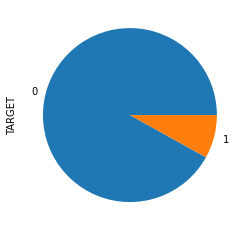

In [47]:
df_application_train['TARGET'].value_counts().plot(kind='pie')

#### Variables catégorielles

In [51]:
target_col = 'TARGET'
if DISPLAY_EDA_GRAPHS :
    for df, df_name in [[df_application_train, 'df_application_train'],
                        # [df_application_test, 'df_application_test'],
                        [df_bureau, 'df_bureau'],
                        [df_bureau_balance, 'df_bureau_balance'],
                        [df_credit_card_balance, 'df_credit_card_balance'],
                        [df_installments_payments, 'df_installments_payments'],
                        [df_POS_CASH_balance, 'df_POS_CASH_balance'],
                        [df_previous_application, 'df_previous_application']]:

        print(bcolors.BOLD+bcolors.HEADER+df_name+'\n'+'-'*len(df_name)+bcolors.ENDC)
        cat_cols = [col for col in df.columns if df[col].dtype == 'object']
        num_cols = list(set(df.columns) - set(cat_cols) - set(['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']))
        feat_cols = num_cols + cat_cols
        all_cols = feat_cols + [target_col]

        plt.rcParams['figure.figsize'] = [15, 6]
        plt.rcParams['axes.titlesize'] = 20
        plt.rcParams['axes.labelsize'] = 14
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12

        n = len(cat_cols)
        ind = 0
        for colonne in cat_cols:
            ind += 1
            DisplotData.trace_tuyaux_principaux(df,colonne, seuil=1., max_bar=50, kind='bar', rot=90, show_nan=True);

#### Variables numériques

In [52]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [53]:
if DISPLAY_EDA_GRAPHS :
    for df, df_name in [[df_application_train, 'df_application_train'],
                        # [df_application_test, 'df_application_test'],
                        [df_bureau, 'df_bureau'],
                        [df_bureau_balance, 'df_bureau_balance'],
                        [df_credit_card_balance, 'df_credit_card_balance'],
                        [df_installments_payments, 'df_installments_payments'],
                        [df_POS_CASH_balance, 'df_POS_CASH_balance'],
                        [df_previous_application, 'df_previous_application']]:

        print(bcolors.BOLD+bcolors.HEADER+df_name+'\n'+'-'*len(df_name)+bcolors.ENDC)
        cat_cols = [col for col in df.columns if df[col].dtype == 'object']
        num_cols = list(set(df.columns) - set(cat_cols) - set(['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU', 'TARGET']))
        feat_cols = num_cols + cat_cols
        all_cols = feat_cols + [target_col]

        n = len(cat_cols)
        print(f"num_cols = {num_cols}")
        print(f"num_cols = {num_cols}")
        DisplotData.plot_distrib(df, num_cols, nbins=100)

**Analyses explo à pousser**
 - [ ] Pourquoi `DAYS_LAST_PHONE_CHANGE` a un énorme pic près de 0 ? 0 = NaN pour cette donnée ? Ca semble être la même chose pour les colonnes `Normalized information about building where the client live`
 - [ ] `EXT_SOURCE_2`, `EXT_SOURCE_3` : idem, mais en tant que var très influente, ne vaut-il pas mieux supprimer les 0.0 ?
 - [ ] idem `DAYS_DECISION`
 - [ ] `AMT_INCOME_TOTAL` : outlier(s) ! XGBoost y sera sensible (à vérifier)
 - [ ] `AMT_ANNUITY`, `AMT_CREDIT_SUM`, `AMT_INCOME_TOTAL`, `AMT_CREDIT_SUM_DEBT`, `AMT_CREDIT_MAX_OVERDUE`, `AMT_CREDIT_SUM_OVERDUE`, `AMT_CREDIT_SUM_LIMIT` : outlier(s) ! XGBoost y sera sensible (à vérifier)
 - [ ] `CREDIT_DAY_OVERDUE`, `CNT_CREDIT_PROLONG` : outlier(s) ?
 - [ ] `AMT_REQ_CREDIT_BUREAU_DAY`, `AMT_REQ_CREDIT_BUREAU_WEEK` quasiment que des 0 et des pouillèmes de 1 et autres (mais niv0)
 - [ ] `DAYS_CREDIT_ENDDATE` : encore un 365000 qui n'a pas été nettoyé ? (niv3)
 - [ ] `DAYS_CREDIT_UPDATE` : un -365000 qui n'a pas été nettoyé ? (niv1)
 - [ ] `DAYS_ENDDATE_FACT` : un -365000 qui n'a pas été nettoyé ? (niv1)

In [54]:
df_application_train['FLAG_OWN_REALTY'].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

### Etudes bivariées

### Etudes multivariées 

#### ACP de visu

In [56]:
selected_features_file = data_dir+'selected_features.csv'
selected_features = read_feature_selection(selected_features_file, min_level=3)
selected_features.head()

,Column1,Table,Row,Traduction description,Non-relaxable,Interet (0-3),Commentaire interet,Operations,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID de pret dans notre echantillon,0,3.0,NaN,NaN,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Variable cible (1 - Client avec difficultes de...,0,3.0,NaN,NaN,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification si le pret est cash ou revolving,1,3.0,Revolving = plutet surendettatoire,NaN,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Sexe du client,1,3.0,LGBM2,NaN,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag Si le client possede une voiture,1,3.0,NaN,NaN,Flag if the client owns a car,NaN


In [58]:
# debug = True
df_prep, cat_cols, num_cols = preprocess(selected_features=selected_features, num_rows=100000) # 
acp_df = df_prep[df_prep['TARGET'].notnull()].copy()
acp_df = acp_df.dropna(axis=0)
del(df_prep)

Train samples: 100000, test samples: 48744
Bureau df shape: (305811, 87)
Process bureau and bureau_balance - done in 11s
Previous applications df shape: (338857, 38)
Process previous_applications - done in 3s
Pos-cash balance df shape: (337252, 15)
Process POS-CASH balance - done in 6s
Installments payments df shape: (339587, 4)
Process installments payments - done in 2s
Credit card balance df shape: (103558, 61)
Process credit card balance - done in 5s


In [59]:
# On ne retient que les colonnes numériques continues

In [60]:
# cols = [col for col in acp_df.columns if acp_df[col].dtype!='object']
cols = [col for col in acp_df.columns if '_NR' not in col]
acp_df = acp_df[cols]

In [61]:
acp_df

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_AMT_CREDIT_SUM_OVERDUE#MIN,BURO_AMT_CREDIT_SUM_OVERDUE#MAX,BURO_AMT_CREDIT_SUM_OVERDUE#MEAN,BURO_DAYS_CREDIT#MAX,BURO_AMT_CREDIT_SUM#MAX,BURO_AMT_CREDIT_SUM#MEAN,BURO_AMT_CREDIT_SUM#SUM,BURO_AMT_CREDIT_MAX_OVERDUE#MIN,BURO_AMT_CREDIT_MAX_OVERDUE#MAX,BURO_AMT_CREDIT_MAX_OVERDUE#MEAN,BURO_DAYS_CREDIT_ENDDATE#MIN,BURO_DAYS_CREDIT_ENDDATE#MAX,BURO_DAYS_CREDIT_ENDDATE#MEAN,BURO_CREDIT_DAY_OVERDUE#MIN,BURO_CREDIT_DAY_OVERDUE#MAX,BURO_CREDIT_DAY_OVERDUE#MEAN,BURO_AMT_CREDIT_SUM_DEBT#MIN,BURO_AMT_CREDIT_SUM_DEBT#MAX,BURO_AMT_CREDIT_SUM_DEBT#MEAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE#MIN,ACTIVE_AMT_CREDIT_SUM_OVERDUE#MAX,ACTIVE_AMT_CREDIT_SUM_OVERDUE#MEAN,ACTIVE_DAYS_CREDIT#MAX,ACTIVE_AMT_CREDIT_SUM#MAX,ACTIVE_AMT_CREDIT_SUM#MEAN,ACTIVE_AMT_CREDIT_SUM#SUM,ACTIVE_AMT_CREDIT_MAX_OVERDUE#MIN,ACTIVE_AMT_CREDIT_MAX_OVERDUE#MAX,ACTIVE_AMT_CREDIT_MAX_OVERDUE#MEAN,ACTIVE_DAYS_CREDIT_ENDDATE#MIN,ACTIVE_DAYS_CREDIT_ENDDATE#MAX,ACTIVE_DAYS_CREDIT_ENDDATE#MEAN,ACTIVE_CREDIT_DAY_OVERDUE#MIN,ACTIVE_CREDIT_DAY_OVERDUE#MAX,ACTIVE_CREDIT_DAY_OVERDUE#MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT#MIN,ACTIVE_AMT_CREDIT_SUM_DEBT#MAX,ACTIVE_AMT_CREDIT_SUM_DEBT#MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE#MIN,CLOSED_AMT_CREDIT_SUM_OVERDUE#MAX,CLOSED_AMT_CREDIT_SUM_OVERDUE#MEAN,CLOSED_DAYS_CREDIT#MAX,CLOSED_AMT_CREDIT_SUM#MAX,CLOSED_AMT_CREDIT_SUM#MEAN,CLOSED_AMT_CREDIT_SUM#SUM,CLOSED_AMT_CREDIT_MAX_OVERDUE#MIN,CLOSED_AMT_CREDIT_MAX_OVERDUE#MAX,CLOSED_AMT_CREDIT_MAX_OVERDUE#MEAN,CLOSED_DAYS_CREDIT_ENDDATE#MIN,CLOSED_DAYS_CREDIT_ENDDATE#MAX,CLOSED_DAYS_CREDIT_ENDDATE#MEAN,CLOSED_CREDIT_DAY_OVERDUE#MIN,CLOSED_CREDIT_DAY_OVERDUE#MAX,CLOSED_CREDIT_DAY_OVERDUE#MEAN,CLOSED_AMT_CREDIT_SUM_DEBT#MIN,CLOSED_AMT_CREDIT_SUM_DEBT#MAX,CLOSED_AMT_CREDIT_SUM_DEBT#MEAN,PREV_AMT_GOODS_PRICE#MIN,PREV_AMT_GOODS_PRICE#MAX,PREV_AMT_GOODS_PRICE#MEAN,PREV_DAYS_DECISION#MIN,PREV_DAYS_DECISION#MAX,PREV_DAYS_DECISION#MEAN,APPROVED_AMT_GOODS_PRICE#MIN,APPROVED_AMT_GOODS_PRICE#MAX,APPROVED_AMT_GOODS_PRICE#MEAN,APPROVED_DAYS_DECISION#MIN,APPROVED_DAYS_DECISION#MAX,APPROVED_DAYS_DECISION#MEAN,REFUSED_AMT_GOODS_PRICE#MIN,REFUSED_AMT_GOODS_PRICE#MAX,REFUSED_AMT_GOODS_PRICE#MEAN,REFUSED_DAYS_DECISION#MIN,REFUSED_DAYS_DECISION#MAX,REFUSED_DAYS_DECISION#MEAN,POS_SK_DPD#MAX,POS_SK_DPD#MEAN,POS_SK_DPD_DEF#MAX,POS_SK_DPD_DEF#MEAN,INSTAL_DAYS_ENTRY_PAYMENT#MAX,INSTAL_DAYS_ENTRY_PAYMENT#MEAN,INSTAL_DAYS_ENTRY_PAYMENT#SUM,CC_AMT_BALANCE#MIN,CC_AMT_BALANCE#MAX,CC_AMT_BALANCE#MEAN,CC_AMT_BALANCE#SUM,CC_AMT_BALANCE#VAR,CC_AMT_RECEIVABLE_PRINCIPAL#MIN,CC_AMT_RECEIVABLE_PRINCIPAL#MAX,CC_AMT_RECEIVABLE_PRINCIPAL#MEAN,CC_AMT_RECEIVABLE_PRINCIPAL#SUM,CC_AMT_RECEIVABLE_PRINCIPAL#VAR,CC_AMT_RECIVABLE#MIN,CC_AMT_RECIVABLE#MAX,CC_AMT_RECIVABLE#MEAN,CC_AMT_RECIVABLE#SUM,CC_AMT_RECIVABLE#VAR,CC_SK_DPD#MIN,CC_SK_DPD#MAX,CC_SK_DPD#MEAN,CC_SK_DPD#SUM,CC_SK_DPD#VAR
135,100157,0.0,180000.0,1755000.0,61132.5,-16086,-3174.0,-4584,0.867872,0.147685,0.669057,0.0,0.096295,0.102564,90000.0,0.339625,0.034833,0.0,0.0,0.000,-159.0,450000.000,196035.012000,980175.060,0.0,0.000,0.000000,-2382.0,1667.0,-460.200000,0.0,0.0,0.000000,0.0,432603.000,86520.600000,0.0,0.0,0.000,-159.0,450000.00,4.500000e+05,450000.000,0.000,0.000,0.00000,1667.0,1667.0,1667.000000,0.0,0.0,0.000000,432603.0,432603.000,432603.000000,0.0,0.0,0.0,-1278.0,408352.500,132543.765000,530175.060,0.0,0.000,0.0000,-2382.0,493.0,-992.000000,0.0,0.0,0.0,0.0,0.0,0.0,49495.50,78718.5,68977.500000,-1934.0,-265.0,-1435.800000,49495.50,78718.5,64107.0000,-1934.0,-1430.0,-1660.000000,78718.5,78718.5,78718.50,-1934.0,-1934.0,-1934.000000,0.0,0.000000,0.0,0.000000,-1333.0,-1626.727273,-35788.0,0.000,0.000,0.000000,0.000,0.000000e+00,0.000,0.000,0.000000,0.000,0.000000e+00,0.000,0.000,0.000000,0.000,0.000000e+00,0.0,0.0,0.00000,0.0,0.000000
153,100180,0

In [62]:
from sklearn.decomposition import PCA

In [63]:
X_train_pca = acp_df[cols].drop(['TARGET'], axis=1)
y = acp_df[['TARGET']]

# Centrage et Réduction
std_scale = StandardScaler().fit(X_train_pca)
X_train_pca_scaled = std_scale.transform(X_train_pca)
# Calcul des composantes principales
pca = PCA(n_components=2)
pca.fit(X_train_pca_scaled)
X_train_pca_proj = pca.transform(X_train_pca_scaled)
# DataFrame
# X_train_pca_proj = pd.DataFrame(X_train_pca_proj,index=X_train_pca.index)


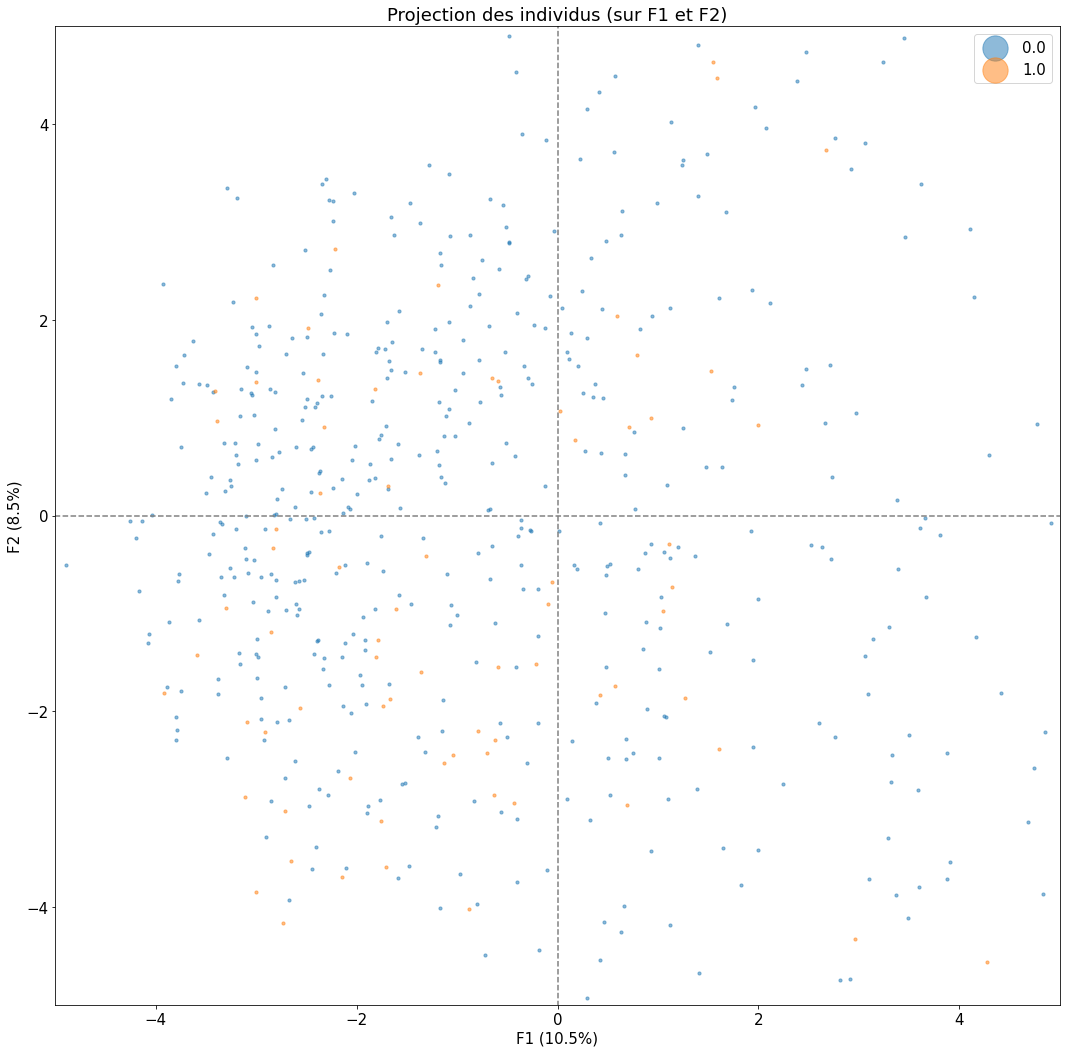

In [64]:
plt.rcParams['figure.figsize'] = [18, 18]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
illustrative_var = [str(val[0]) for val in y.values]
DisplotML.display_factorial_planes(X_train_pca_proj, 2, pca, [(0,1)], alpha=0.5, labels=None,
                                   marker='o', s=10 , illustrative_var=illustrative_var,
                                   xlim=[-5.,5.], ylim=[-5.,5.]
                                  )
plt.show()

On a un "overlapping" assez important, mais difficile de conclure sur une ACP.

# Premiers modèles 

## Variables : toutes

In [65]:
submission_file_name = "submission_kernel02.csv"

In [2]:
debug = False
df_prep, cat_cols, num_cols = preprocess(selected_features=None, debug=debug)

NameError: name 'preprocess' is not defined

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run RandomForest"):
    feat_importance_rf, train_df_rf, test_df_rf = kfold_algo(df, cat_cols, num_cols, algo_name='RandomForest', n_folds=5, stratified=True, debug=debug)
%store feat_importance_rf
%store train_df_rf
%store test_df_rf

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run XGBoost"):
    feat_importance_xgb, train_df_xgb, test_df_xgb = kfold_algo(df, cat_cols, num_cols, algo_name='XGBoost', n_folds=5, stratified=True, debug=debug)
%store feat_importance_xgb
%store train_df_xgb
%store test_df_xgb

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run LightGBM with kfold"):
    feat_importance_lgbm, train_df_lgbm, test_df_lgbm = kfold_lightgbm(df, n_folds=10, stratified=True, debug=debug)
%store feat_importance_lgbm
%store train_df_lgbm
%store test_df_lgbm

## Variables de niveau 2 et 3

In [ ]:
selected_features_file = data_dir+'selected_features.csv'
selected_features = read_feature_selection(selected_features_file, min_level=2)
selected_features.head()

In [ ]:
debug = False
df_prep, cat_cols, num_cols = preprocess(selected_features=selected_features, debug=debug)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run RandomForest"):
    feat_importance_rf, train_df_rf, test_df_rf = kfold_algo(df, cat_cols, num_cols, algo_name='RandomForest', n_folds=5, stratified=True, debug=debug)
# %store feat_importance_rf
# %store train_df_rf
# %store test_df_rf

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run XGBoost"):
    feat_importance_xgb, train_df_xgb, test_df_xgb = kfold_algo(df, cat_cols, num_cols, algo_name='XGBoost', n_folds=5, stratified=True, debug=debug)
# %store feat_importance_xgb
# %store train_df_xgb
# %store test_df_xgb

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run LightGBM with kfold"):
    feat_importance_lgbm, train_df_lgbm, test_df_lgbm = kfold_lightgbm(df, n_folds=10, stratified=True, debug=debug)
# %store feat_importance_lgbm
# %store train_df_lgbm
# %store test_df_lgbm

## Variables de niveau 3

In [ ]:
selected_features_file = data_dir+'selected_features.csv'
selected_features = read_feature_selection(selected_features_file, min_level=3)
selected_features.head()

In [ ]:
debug = True
df_prep, cat_cols, num_cols = preprocess(selected_features=selected_features, debug=debug, num_rows=10000)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run RandomForest"):
    feat_importance_rf, train_df_rf, test_df_rf = kfold_algo(df, cat_cols, num_cols, algo_name='RandomForest', n_folds=5, stratified=True, debug=debug)
# %store feat_importance_rf
# %store train_df_rf
# %store test_df_rf

In [ ]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run XGBoost"):
    feat_importance_xgb, train_df_xgb, test_df_xgb = kfold_algo(df, cat_cols, num_cols, algo_name='XGBoost', n_folds=5, stratified=True, debug=debug)
# %store feat_importance_xgb
# %store train_df_xgb
# %store test_df_xgb

In [3]:
train_df_xgb

NameError: name 'train_df_xgb' is not defined

In [4]:
plt.rcParams['figure.figsize'] = [10, 30]
with timer("Run LightGBM with kfold"):
    feat_importance_lgbm, train_df_lgbm, test_df_lgbm = kfold_lightgbm(df, n_folds=10, stratified=True, debug=debug)
# %store feat_importance_lgbm
# %store train_df_lgbm
# %store test_df_lgbm

NameError: name 'plt' is not defined

In [ ]:
df_application_train['NAME_TYPE_SUITE'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 2]
display_importances(feature_importance_df_essai, 3)

DCQJC, on a tout à fait le droit d'ajouter les informations provenant des autres tables, et celles que l'on a créées, aux Dataframes train et test.

In [5]:
submission_file_name = "submission_kernel02.csv"

In [6]:
feature_importance_df_lgbm = feature_importance_df

NameError: name 'feature_importance_df' is not defined

In [ ]:
df.shape

In [ ]:
%store feat_importance_lgbm
%store train_df_lgbm
%store test_df_lgbm

In [ ]:
%store -r feat_importance_lgbm
%store -r train_df_lgbm
%store -r test_df_lgbm

In [ ]:
plt.rcParams['figure.figsize'] = [10, 40]
display_importances(feat_importance_lgbm, 200)

In [7]:
feat_importance = feat_importance_lgbm.copy()

NameError: name 'feat_importance_lgbm' is not defined

In [ ]:
# for col, val in feat_importance[['feature', 'importance']].values:
fi = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
for col, val in zip(fi.index, fi.values):
    if 'NAME_CONTRACT_STATUS' in col: #ACTIVE_, CLOSED_, BURO_
        print(col, val)

In [ ]:
df_POS_CASH_balance['NAME_CONTRACT_STATUS'].value_counts()

In [8]:
df_bureau

NameError: name 'df_bureau' is not defined

In [ ]:
df_bureau['AMT_CREDIT_SUM']#.value_counts()

On peut par exemple retenir les colonnes jusqu'à `CLOSED_AMT_CREDIT_SUM_MEAN`

# DOE

## Score personnalisé

In [71]:
def custom_metric1(y_true, y_pred, X_train): # needs_proba=True ?
#     TP, FN, FP, TN = confusion_matrix(y_actual, y_pred).ravel().tolist()
#     cost = (60*TP+ 0*FN + 10*FP + 10*TN)/y_actual.size
    # False Positive : on perd le bénéfice du prêt, càd AMT_ANNUITY
    # False Negative : on perd le reste à rembourser, çàd AMT_CREDIT dans le pire des cas
    # True Positive : on gagne le bénéfice du prêt
    # True Negative : on ne perd ni ne gagne rien
#     print(f"X_train.shape AVANT = {X_train.shape}")
    X_work = X_train.loc[y_true.index].copy()
#     print(f"X_work.shape APRES = {X_work.shape}")
#     print(f"y_true.shape APRES = {y_true.shape}")
#     print(f"y_pred.shape APRES = {y_pred.shape}")
#     print(f"X_work.index = {X_work.index}")
#     print(f"y_pred.index = {y_pred.index}")
#     print(f"y_true.index = {y_true.index}")
#     print(f"y_true = {y_true}")
#     print(f"y_pred = {y_pred}")
    selected_TN = (y_pred==0) & (y_true==0)
    
    gain_TN = X_work.loc[selected_TN, 'AMT_ANNUITY'].sum()
    
    selected_FP = (y_pred==1) & (y_true==0)
    gain_FP = X_work.loc[selected_FP, 'AMT_ANNUITY'].sum()
    
    selected_FN = (y_pred==0) & (y_true==1)
    gain_FN = X_work.loc[selected_FN, 'AMT_CREDIT'].sum()
    
    selected_TP = (y_pred==1) & (y_true==1)
    gain_TP = 0. # Normalement, on n'a pas réalisé le prêt
    gain = gain_TN - gain_FP - gain_FN + gain_TP
#     print(f"selected_TN.sum() = {selected_TN.sum()}")
#     print(f"selected_FP.sum() = {selected_FP.sum()}")
#     print(f"selected_FN.sum() = {selected_FN.sum()}")
#     print(f"selected_TP.sum() = {selected_TP.sum()}")
    ai = selected_TN.sum()+selected_FP.sum()+selected_FN.sum()+selected_TP.sum()
    if ai!=y_true.shape: print(f"*** MALHEUR !!! Tus lis indices = {ai}, or y_true.shape = {y_true.shape}")
#     print(f"gain = {gain}")
    return gain

Regarder la "somme" des deux indicateurs, dans le datset
On peut aussi travailler avec des montants moyens, si on n'est pas certain des colonnes

In [72]:
def custom_metric(y_true, y_pred, X_train): # needs_proba=True ?
    # False Positive : on perd le bénéfice du prêt, càd AMT_ANNUITY
    # False Negative : on perd le reste à rembourser, çàd AMT_CREDIT dans le pire des cas
    # True Positive : on gagne le bénéfice du prêt
    # True Negative : on ne perd ni ne gagne rien
    X_work = X_train.loc[y_true.index].copy()
    print(f"y_pred.shape = {y_pred.shape}")
    y_pred = y_pred.reshape(-1,)
    print(f"y_true.shape = {y_true.shape}")
    print(f"y_pred.shape APRES = {y_pred.shape}")
    
    selected_TN = (y_true==0) # (y_pred==0) & 
    selected_FP = (y_true==0) # (y_pred==1) & 
    selected_FN = (y_true==1) # (y_pred==0) & 
    selected_TP = (y_true==1) # (y_pred==1) & 
    
    gain_TN = (1. - y_pred) * X_work.loc[selected_TN, 'AMT_ANNUITY']
    gain_FP = y_pred * X_work.loc[selected_FP, 'AMT_ANNUITY']
    gain_FN = (1. - y_pred) * X_work.loc[selected_FN, 'AMT_CREDIT']
    gain_TP = y_pred * X_work.loc[selected_TP, 'AMT_CREDIT'] # Plus on détecte un vrai positif, plus on gagne la perte qu'on aurait fait
    
    gain = gain_TN.sum() - gain_FP.sum() - gain_FN.sum() + gain_TP.sum()
#     ai = selected_TN.sum()+selected_FP.sum()+selected_FN.sum()+selected_TP.sum()
#     if ai!=y_true.shape: print(f"*** MALHEUR !!! Tus lis indices = {ai}, or y_true.shape = {y_true.shape}")
    print(f"gain = {gain}")
    return gain

In [73]:
def custom_metric_threshold(y_true, y_pred_1, X_train, threshold=0.5):
    """Fonction custom de scoring, calculant un bilan financier en fonction d'un seuil de décision
    et des données d'entraînement.
    
    Parameters
    ----------
    y_true : 1D
        Contient les labels réels
    y_pred_1 : 1D
        Contient les probas de la classe 1
    X_train : pandas.DataFrame
        Dataset servant au calcul du bilan financier.
    threshold : float
        Seuil utilisé pour déclarer la prédiction à la valeur 0.
    """
    # False Positive : on perd le bénéfice du prêt, càd AMT_ANNUITY
    # False Negative : on perd le reste à rembourser, çàd AMT_CREDIT dans le pire des cas
    # True Positive : on gagne le bénéfice du prêt
    # True Negative : on ne perd ni ne gagne rien
    
    X_work = X_train.loc[y_true.index].copy()
#     print(f"y_pred_1.shape = {y_pred_1.shape}")
#     print(f"y_pred_1 = {y_pred_1}")
#     print(f"y_true.shape = {y_true.shape}")
#     print(f"threshold = {threshold}")
    y_pred_0 = 1. - y_pred_1
    is_acceptable = (y_pred_0 >= threshold) # On regarde la probabilité d'un Négatif
    
    selected_TN = (is_acceptable)  & (y_true==0)
    selected_FP = (~is_acceptable) & (y_true==0)
    selected_FN = (is_acceptable)  & (y_true==1)
    selected_TP = (~is_acceptable) & (y_true==1)
    
    gain_TN = X_work.loc[selected_TN, 'AMT_ANNUITY'] #* y_pred_0[selected_TN] # On pondère par la proba associée
    gain_FP = X_work.loc[selected_FP, 'AMT_ANNUITY'] #* y_pred_0[selected_FP]
    gain_FN = X_work.loc[selected_FN, 'AMT_CREDIT' ] #* y_pred_1[selected_FN]
    gain_TP = 0. #* y_pred_1[selected_FN] # On ne gagne ni ne perd rien
    
    gain = gain_TN.sum() - gain_FP.sum() - gain_FN.sum() + gain_TP.sum()
#     ai = selected_TN.sum()+selected_FP.sum()+selected_FN.sum()+selected_TP.sum()
#     if ai!=y_true.shape: print(f"*** MALHEUR !!! Tus lis indices = {ai}, or y_true.shape = {y_true.shape}")
#     print(f"gain = {gain}")
    return gain

# custom_score_threshold = make_scorer(custom_metric_threshold, greater_is_better=True, needs_proba=True, X_train=train_df, threshold=0.5)

## Préparation

In [74]:
submission_file_name = "submission_kernel.csv"

In [75]:
selected_features_file = data_dir+'selected_features.csv'
selected_features = read_feature_selection(selected_features_file, min_level=3)
selected_features.head()

,Column1,Table,Row,Traduction description,Non-relaxable,Interet (0-3),Commentaire interet,Operations,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID de pret dans notre echantillon,0,3.0,NaN,NaN,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Variable cible (1 - Client avec difficultes de...,0,3.0,NaN,NaN,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification si le pret est cash ou revolving,1,3.0,Revolving = plutet surendettatoire,NaN,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Sexe du client,1,3.0,LGBM2,NaN,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag Si le client possede une voiture,1,3.0,NaN,NaN,Flag if the client owns a car,NaN


In [76]:
debug = True
df_prep, cat_cols, num_cols = preprocess(selected_features=selected_features, debug=debug, num_rows=50000) # 
train_df = df_prep[df_prep['TARGET'].notnull()]

Train samples: 3000, test samples: 3000
Bureau df shape: (305811, 87)
Process bureau and bureau_balance - done in 22s
Previous applications df shape: (338857, 38)
Process previous_applications - done in 5s
Pos-cash balance df shape: (337252, 15)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 4)
Process installments payments - done in 3s
Credit card balance df shape: (103558, 61)
Process credit card balance - done in 8s


In [100]:
test_df = df_prep[df_prep['TARGET'].isnull()]

In [101]:
df_bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [106]:
n_ind = {}
for df, df_name in [[df_application_train, 'df_application_train'],
                    # [df_application_test, 'df_application_test'],
                    [df_bureau, 'df_bureau'],
                    [df_bureau_balance, 'df_bureau_balance'],
                    [df_credit_card_balance, 'df_credit_card_balance'],
                    [df_installments_payments, 'df_installments_payments'],
                    [df_POS_CASH_balance, 'df_POS_CASH_balance'],
                    [df_previous_application, 'df_previous_application']]:
    n = 0
    for ind in test_df.index:
        if ind in df.index:
            n += 1
    n_ind[df_name] = n
print(n_ind)

{'df_application_train': 3000, 'df_bureau': 3000, 'df_bureau_balance': 3000, 'df_credit_card_balance': 3000, 'df_installments_payments': 3000, 'df_POS_CASH_balance': 3000, 'df_previous_application': 3000}


In [103]:
df_prep.shape

(6000, 251)

In [77]:
train_df['TARGET'].value_counts()

0.0    2763
1.0     237
Name: TARGET, dtype: int64

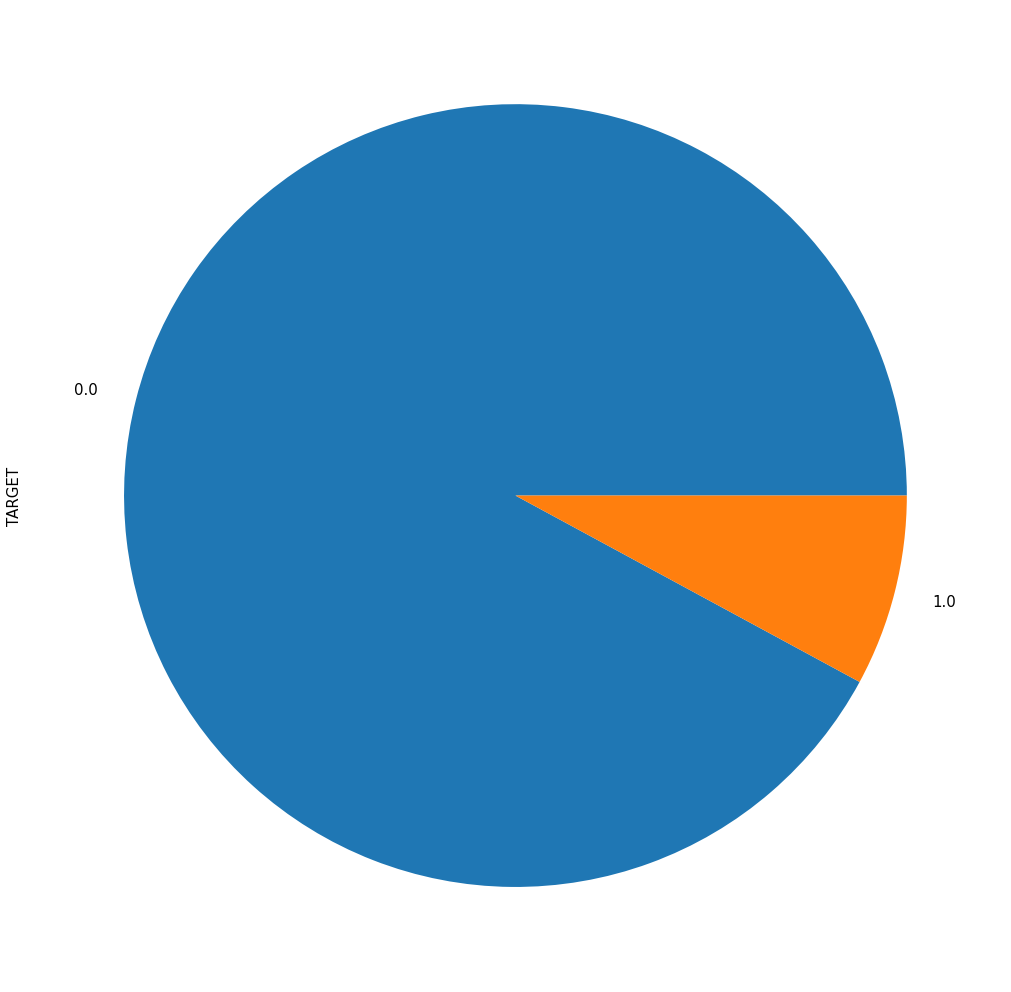

In [78]:
train_df['TARGET'].value_counts().plot(kind='pie')

In [79]:
for col in train_df.columns:
    print(col)

SK_ID_CURR
TARGET
CODE_GENDER_NR
FLAG_OWN_CAR_NR
FLAG_OWN_REALTY_NR
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
DAYS_BIRTH
DAYS_EMPLOYED_NR
DAYS_REGISTRATION
DAYS_ID_PUBLISH
CNT_FAM_MEMBERS_NR
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
DAYS_LAST_PHONE_CHANGE
NAME_CONTRACT_TYPE__Cash loans_NR
NAME_CONTRACT_TYPE__Revolving loans_NR
NAME_INCOME_TYPE__Businessman_NR
NAME_INCOME_TYPE__Commercial associate_NR
NAME_INCOME_TYPE__Pensioner_NR
NAME_INCOME_TYPE__State servant_NR
NAME_INCOME_TYPE__Unemployed_NR
NAME_INCOME_TYPE__Working_NR
NAME_EDUCATION_TYPE__Academic degree_NR
NAME_EDUCATION_TYPE__Higher education_NR
NAME_EDUCATION_TYPE__Incomplete higher_NR
NAME_EDUCATION_TYPE__Lower secondary_NR
NAME_EDUCATION_TYPE__Secondary / secondary special_NR
NAME_FAMILY_STATUS__Civil marriage_NR
NAME_FAMILY_STATUS__Married_NR
NAME_FAMILY_STATUS__Separated_NR
NAME_FAMILY_STATUS__Single / not married_NR
NAME_FAMILY_STATUS__Widow_NR
NAME_HOUSING_TYPE__Co-op apartment_NR
NAME_HOUSING_TYPE__House / apartment_NR
NAME

0.0    90
1.0    10
Name: TARGET, dtype: int64


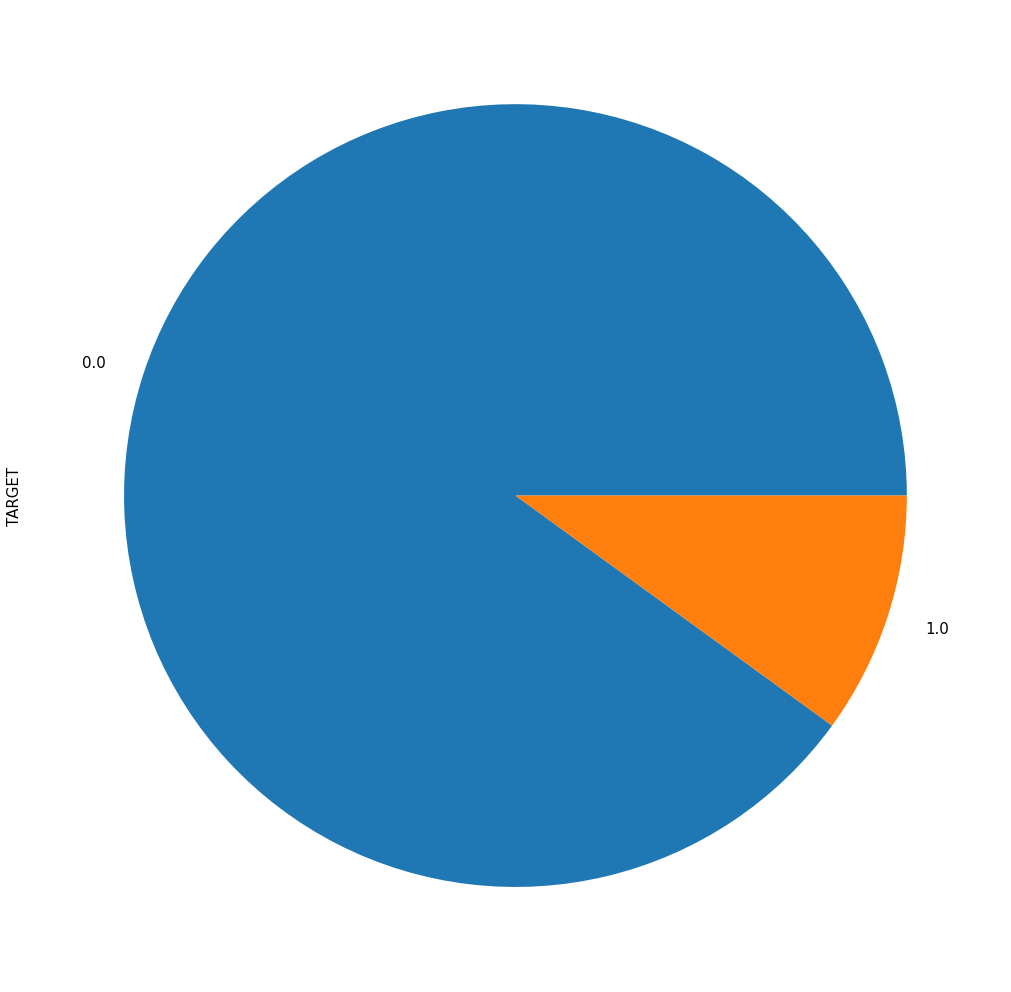

In [80]:
mini_train_df = train_df.sample(n=100, random_state=18011975)
print(mini_train_df['TARGET'].value_counts())
mini_train_df['TARGET'].value_counts().plot(kind='pie')

In [81]:
from collections import Counter

In [82]:
y = train_df['TARGET']

In [83]:
counter = Counter(y)
weight = counter[0] / counter[1]
weight

11.658227848101266

In [84]:
problem_kind = 'classification'
scores = ['roc_auc'] # [custom_score, 'roc_auc', 'precision', 'recall', 'f1'] # , 'custom_score'
target_col = 'TARGET'

In [85]:
scalers = [StandardScaler] # StandardScaler, MinMaxScaler, QuantileTransformer(output_distribution='uniform') ?
# encoders = [OneHotEncoder(sparse=False,handle_unknown='ignore')]
encoders = [[]]

### Algorithmes

In [86]:
# Dictionnaires d'hyperparamètres
param_grid_dum = {}

# param_grid_knn  = {'n_neighbors': range(1, 51)}
# param_grid_svc = {'C': np.logspace(-3, 3, 10)}

weights = np.linspace(0.05, 0.95, 20)
param_grid_lr = {
    'class_weight': [None, 'balanced'], #, {0: x, 1: 1.0-x} for x in weights
    'C': [0.0001, 0.001, 0.01],
    'dual': [False],
    'fit_intercept': [True],
    'intercept_scaling': [1],
    'max_iter': [1000],
    'multi_class': ['ovr'],
    'penalty': ['l2'],
    'random_state': [None],
    'solver': ['liblinear'], 'n_jobs': [1], # n_jobs=1 pour liblinear
    'tol': [0.0001],
    'warm_start': [False],
    'random_state': [18011975],
}

param_grid_xgbc = {
#     'scale_pos_weight': [weight],
    'n_estimators': [1000],  # [20, 50, 100, 200], [500, 1000, 10000]
    'learning_rate': [0.05],  # [0.01, 0.05, 0.1, 0.3],
    'max_depth': [5],
    'colsample_bytree': [0.8],  # [0.5, 1.],
#     'subsample': [0.5, 0.7, 1.],
#     'gamma': [1., 5., 10.],
#     'min_child_weight': [5., 7.],
#     'colsample_bytree':
#     'max_depth': [1, 3, 6],
#     'alpha': [1., 100., 200.],
    'nthread': [10],
    'random_state': [18011975],
}

param_grid_lgbc = {
    'nthread': [4],
    'n_estimators': [10000],
    'learning_rate': [0.02],
    'num_leaves': [34],
    'colsample_bytree': [0.9497036],
    'subsample': [0.8715623],
    'max_depth': [8],
    'reg_alpha': [0.041545473],
    'reg_lambda': [0.0735294],
    'min_split_gain': [0.0222415],
    'min_child_weight': [39.3259775],
    'verbose': [-1],
    'random_state': [18011975],
#     'silent': [-1],
}

param_grid_rfc = {
    'n_estimators': [200, 500], #[20, 50, 100, 200]
    'max_depth': [None, 2], #[None, 1, 2, 5],
    'min_samples_split': [2, 5], #[2, 5, 10],
    'random_state': [18011975],
}

In [87]:
algos_clf = [
#     {'surname': 'Dummy stratified',
#      'class': DummyClassifier(strategy='stratified'),
#      'param_grid': param_grid_dum},
#     {'surname': 'SVC', # utilise un OVO, histoire de comparer
#      'class': SVC(kernel='linear'),
#      'param_grid': param_grid_svc},
#     {'surname': 'kNN',
#      'class': KNeighborsClassifier(),
#      'param_grid': param_grid_knn},
    
    {'surname': 'Logistic',
     'class': LogisticRegression(verbose=0), # class_weight='balanced'
     'param_grid': param_grid_lr},
    {'surname': 'XGBoost', # ne fonctionne pas car trop peu de samples pour certaines classes
    'class': XGBClassifier(), # 
    'param_grid': param_grid_xgbc},
#     {'surname': 'LightGBM',
#      'class': LGBMClassifier(), # class_weight={0:1, 1:10}
#      'param_grid': param_grid_lgbc},
#     {'surname': 'RandomForest',
#      'class': RandomForestClassifier(), # class_weight={0:1, 1:10}
#      'param_grid': param_grid_rfc},
]

### Scores et seuils

In [88]:
custom_score1 = make_scorer(custom_metric1, greater_is_better=True, X_train=train_df)

In [89]:
custom_score = make_scorer(custom_metric, greater_is_better=True, X_train=train_df, needs_proba=True)

In [90]:
scoring_data = [
    {'score_function': custom_metric_threshold,
     'greater_is_better': True,
     'needs_proba': True,
     'score_params': {'X_train': train_df,
                      'threshold': 0.51}},
    {'score_function': custom_metric_threshold,
     'greater_is_better': True,
     'needs_proba': True,
     'score_params': {'X_train': train_df,
                      'threshold': 0.80}},
    {'score_function': custom_metric_threshold,
     'greater_is_better': True,
     'needs_proba': True,
     'score_params': {'X_train': train_df,
                      'threshold': 0.95}},
    {'score_function': custom_metric_threshold,
     'greater_is_better': True,
     'needs_proba': True,
     'score_params': {'X_train': train_df,
                      'threshold': 0.99}},
]

In [91]:
scoring_data = [
    {'score_function': custom_metric_threshold,
     'greater_is_better': True,
     'needs_proba': True,
     'score_params': {'X_train': train_df,
                      'threshold': s/100.}} for s in range(50,100)
]

### Variables sélectionnées

In [92]:
models_cols = [
    {'categ_cols':[], # Tout est déjà encodé
     'num_cols'  :[f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']],
    },
]

In [93]:
chosen_models_cols = models_cols #[5:6]# [2:6:3]

In [94]:
doe = list(itertools.product(algos_clf, encoders, scalers, chosen_models_cols, scoring_data))
columns = ['Algorithm', 'Encoder', 'Scaler', 'Variables', 'Scoring data']
df_doe = pd.DataFrame(data=doe, columns=columns)
df_doe_init = df_doe.copy()

In [95]:
df_doe_init

,Algorithm,Encoder,Scaler,Variables,Scoring data
0,"{'surname': 'Logistic', 'class': LogisticRegre...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
1,"{'surname': 'Logistic', 'class': LogisticRegre...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
2,"{'surname': 'Logistic', 'class': LogisticRegre...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
3,"{'surname': 'Logistic', 'class': LogisticRegre...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
4,"{'surname': 'Logistic', 'class': LogisticRegre...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
...,...,...,...,...,...
95,"{'surname': 'XGBoost', 'class': XGBClassifier(...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
96,"{'surname': 'XGBoost', 'class': XGBClassifier(...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
97,"{'surname': 'XGBoost', 'class': XGBClassifier(...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...
98,"{'surname': 'XGBoost', 'class': XGBClassifier(...",[],<class 'sklearn.preprocessing._data.StandardSc...,"{'categ_cols': [], 'num_cols': ['CODE_GENDER_N...",{'score_function': <function custom_metric_thr...


## Lancement

In [96]:
# mini_train_df.shape
train_df.shape

(3000, 251)

In [98]:
test_df

NameError: name 'test_df' is not defined

In [97]:
##################
# AVEC Under
##################
df_doe_overunder, algos_results, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=False, undersampling=True,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_overunder # Avec over/undersampling

Taille du dataset de classification  : (3000, 251)
Taille du dataset d'entrainement : (2400, 249)

Algorithme Logistic :
---------------------

y_train.value_counts() = 0.0    2210
1.0     190
Name: TARGET, dtype: int64
Resampling dataset...
Dataset resampled.
y_train_temp.value_counts() = 0.0    190
1.0    190
Name: TARGET, dtype: int64
+++ AVEC over/undersampling


c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\a072108\AppData\Local\Temp\ipykernel_19084\1592148158.py", line 39, in custom_metric_threshold
    gain = gain_TN.sum() - gain_FP.sum() - gain_FN.sum() + ga

c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\a072108\AppData\Local\Temp\ipykernel_19084\1592148158.py", line 39, in custom_metric_threshold
    gain = gain_TN.sum() - gain_FP.sum() - gain_FN.sum() + ga

c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\a072108\AppData\Local\Temp\ipykernel_19084\1592148158.py", line 39, in custom_metric_threshold
    gain = gain_TN.sum() - gain_FP.sum() - gain_FN.sum() + ga

y_train_pred = [0.5004797  0.49916872 0.51697333 ... 0.49688002 0.48889318 0.49485441]


c:\users\public\wpython\v_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  category=UserWarning,


AttributeError: 'float' object has no attribute 'sum'

In [ ]:
df_etude_param_seuil = df_doe_overunder.copy()
df_etude_param_seuil['Seuil'] = np.array(list(range(50,100))*2)/100.
df_etude_param_seuil['Algo'] = [str(ch['surname']) for ch in df_etude_param_seuil['Algorithm'].values]
# %store df_etude_param_seuil

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
fig = plt.figure()
sns.scatterplot(data=df_etude_param_seuil, x='Seuil', y='Test custom_score', hue='Algo')
plt.grid('on')
plt.show()

#### Smote seul

In [ ]:
##################
# AVEC SMOTE
##################
df_doe_overunder, algos_results, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=True, undersampling=False,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_overunder # Avec over/undersampling

**Observations :**
 - Plus on augmente le nombre de voisins de SMOTE-NC, plus le score se dégrade.
 - RandomOverSampler donne un résultat légèrement supérieur à la baseline (enfin) !

**OK, sans SMOTE mais undersampling :**
On tombe à 620x2 = 1240 sample au lieu de 8000 dans X_train, et le test roc_auc monte à 0.748 (0.737 sans rien). Donc le rééquilibrage par sous-échantillonnage des 0 permet au moins de garder la perf (même si on a beaucoup moins de samples). Pour compléter l'expérience, travailler avec 1240 samples dans X_train directement, càd 1550 sample dans X donne test roc_auc = 0.754 avec un bon randoms_state, 0.664 avec un mauvais.
Donc SMOTE semble pénaliser la perf.

Avec SMOTE seul :
On passe de 620 samples positifs à 4059. Le roc_auc tombe à 0.729. Donc c'est bien SMOTE qui met un peu le boxon.

**Sans SMOTE ni Under**, sur un dataset de même taille qu'après UnderSampling

In [ ]:
##################
# SANS SMOTE/Under
##################
df_doe, algos_results, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df[0:6442], df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=False, undersampling=False,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe # Sans over/undersampling

#### Avec 1550 point seulement

In [ ]:
debug = False
# df_prep_1550, cat_cols, num_cols = preprocess(selected_features=selected_features, debug=debug, num_rows=1550)
df_prep_1550 = df_prep.sample(1550, random_state=31051996)
train_df_1550 = df_prep_1550[df_prep_1550['TARGET'].notnull()]
df_doe_1550, algos_results_1550, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_1550, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=False, undersampling=False,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_1550 # Sans over/undersampling

In [ ]:
from imblearn.over_sampling import SMOTE, SMOTENC

In [ ]:
help(SMOTENC)

In [ ]:
help(ADASYN)

Mentor : dans la mesure où l'on doit donner un décision, autant utiliser un seuil dans la custom score, pour classifier à 0 ou 1 
Utiliser les probas dans la grid search ne permet pas de retourner le seuil optimal dans les futures prises de décisions
--> autant faire une recherche sur grille de ce seuil si on utilise les proba
argmax([0.2 0.8]
[0.3 0.7]
[0.8 0.2]] --> en binaire pas besoin de seuil, c'est le max = 0.8
en multiclasse : c'est le max pour chaque ligne



La grille `linspace` pour `class_weight` n'a que très peu amélioré le résultat (ROC AUC) par rapport à `class_weight='balanced'`. 

In [ ]:
df_doe_5algos_save

### Avec 10000 *autres* points que les 10000 premiers

In [ ]:
df_prep_all_samples, cat_cols, num_cols = preprocess(selected_features=selected_features, debug=debug)

In [ ]:
df_prep_10000 = df_prep_all_samples.sample(10000, random_state=18011975)
train_df_10000 = df_prep_10000[df_prep_10000['TARGET'].notnull()]

#### Baseline

In [ ]:
df_doe_10000, algos_results_10000, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_10000, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=False, undersampling=False,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_10000 # Sans over/undersampling

#### Under only

In [ ]:
help(RandomUnderSampler)

In [ ]:
help(SMOTE)

In [ ]:
df_doe_10000_under, algos_results_10000, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_10000, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=False, undersampling=True,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_10000_under # Sans over/undersampling

#### SMOTE only

In [ ]:
df_doe_10000_over, algos_results_10000, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_10000, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=True, undersampling=False,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_10000_over # Sans over/undersampling

#### SMOTE+Under

In [ ]:
df_doe_10000_overunder, algos_results_10000, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_10000, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=True, undersampling=True,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_10000_overunder # Sans over/undersampling

### Avec un déséquilibre encore plus fort

In [ ]:
df_prep_T0 = df_prep_all_samples.loc[df_prep_all_samples['TARGET']==0].sample(9800, random_state=18011975)
df_prep_T1 = df_prep_all_samples.loc[df_prep_all_samples['TARGET']==1].sample(200, random_state=18011975)
train_df_deseq = pd.concat((df_prep_T0, df_prep_T1)).sample(frac=1)
train_df_deseq['TARGET'].value_counts()

#### Baseline

In [ ]:
df_doe_deseq, algos_results_deseq, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_deseq, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=False, undersampling=False,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_deseq # Sans over/undersampling

#### Under only

In [ ]:
df_doe_deseq_under, algos_results_deseq, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_deseq, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=False, undersampling=True,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_deseq_under # Sans over/undersampling

#### SMOTE only

In [ ]:
df_doe_deseq_over, algos_results_deseq, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_deseq, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=True, undersampling=False,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_deseq_over # Sans over/undersampling

#### SMOTE+Under

In [ ]:
df_doe_deseq_overunder, algos_results_deseq, s, best_mdl, best_mdl_name = \
        MLstuff.classification_doe(train_df_deseq, df_doe_init,
                                   target_col, problem_kind,
                                   scores,
                                   oversampling=True, undersampling=True,
                                   predict_proba=True, class_to_predict=1,
                                   encode_y=False)
df_doe_deseq_overunder

C'est maintenant **certain**, il se passe quelque chose avec SMOTE.

ACP + visu des points 0 et des points 1.

## Affichages

In [ ]:
score = 'Test roc_auc'
ind_best_mdl = df_doe.loc[df_doe[score]==df_doe[score].max()].index
ind_best_mdl = list(ind_best_mdl)[0]
ind_best_mdl

### Courbe ROC AUC

In [ ]:
def generate_auc_roc_curve(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"AUC ROC Curve with Area Under the curve = {auc:.4f}")
    plt.legend() #loc=4
    plt.show()


In [ ]:
X_test_enc = algos_results[ind_best_mdl]['X_test_enc']
y_test = algos_results[ind_best_mdl]['y_test']
y_test_pred = algos_results[ind_best_mdl]['y_test_pred']

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
generate_auc_roc_curve(best_mdl, X_test_enc, y_test)

In [ ]:
other_mdl = algos_results[0]['model'].best_estimator_ # Dummy

In [ ]:
generate_auc_roc_curve(other_mdl, X_test_enc, y_test)

In [ ]:
N = 2
doe_top = MLstuff.result_table_top_N(df_doe, 'Test roc_auc', N)
doe_top.to_csv(f"doe_top_{N}_{target_col}.csv",sep=';')
doe_top

# Interprétation du modèle

In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
#winner = df_doe.loc[df_doe[score].astype(float)==df_doe[score].astype(float).min()]
winner = df_doe.loc[df_doe[score]==df_doe[score].max()]
winner

In [ ]:
res.keys()

In [ ]:
problem = df_doe.iloc[ind_best_mdl]
res           = algos_results[ind_best_mdl] # int(winner.index.values)
algo          = problem['Algorithm']['surname']
X_train_enc   = res['X_train_enc']
X_train       = res['X_train']
y_train       = res['y_train']
X_test_enc    = res['X_test_enc']
y_test        = res['y_test']
y_train_pred  = res['y_train_pred']
y_test_pred   = res['y_test_pred']
feat_cols     = problem['Variables']['categ_cols'] + problem['Variables']['num_cols']
feat_cols_enc = res['Column names']
model         = res['model'].best_estimator_['model']

X_train_enc = pd.DataFrame(X_train_enc, columns=feat_cols) #feat_cols_enc
X_train_enc.index = y_train_pred.index

s = f"{algo} | {model} :\n"
print(s+'-'*(min(124,len(s)-3)))
#     print(feat_cols)

In [ ]:
if algo in ['XGBoost','LightGBM','RandomForest']:
    explainer = shap.TreeExplainer(model, X_train_enc) # GradientExplainer
elif algo in ['Logistic']:
    explainer = shap.LinearExplainer(model, X_train_enc) # GradientExplainer
else:
    print("*** Algo pas prévu.")

## N samples pris au hasard

In [ ]:
N = 100

In [ ]:
X_sampled_enc = X_train_enc.sample(N, random_state=18011975)

In [ ]:
if algo in ['XGBoost','LightGBM','RandomForest']:
    shap_values = explainer.shap_values(X_sampled_enc, check_additivity=False)
elif algo in ['Logistic']:
    shap_values = explainer.shap_values(X_sampled_enc)
else:
    print("*** Algo pas prévu.")

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_train_enc)

In [ ]:
shap.summary_plot(shap_values, X_sampled_enc)

- [XGBoost] : Une variance élevée de solde de compte Credit Card (`CC_AMT_BALANCE_VAR`) a une influence croissante sur la proba d'être défaillant sur le crédit.

`DAYS_EMPLOYED` : plus la valeur est elevée (rouge), plus le modèle augmente la target (vers la défaillance) ?!

In [ ]:
df_application_train['DAYS_EMPLOYED'].describe()

C'est parce que les valeurs sont en relatif par rapport à la date de demande de prêt, donc négatives.

### Un de ces samples

In [ ]:
shap.bar_plot(explainer.shap_values(X_sampled_enc)[0],
             feature_names=X_train_enc.columns,
             max_display=20)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled_enc.iloc[0,:], matplotlib=True)

### Feature importance

In [ ]:
shap.summary_plot(shap_values, X_sampled_enc, plot_type="bar")

#### Regroupement des valeurs catégorielles

In [ ]:
if 0 :
    # On moyenne sur les points samplés
    shap_values_moy = abs(shap_values).mean(axis=0)
    grouped_influences = PwePwocess.influenceCatVal(feat_cols, shap_values_moy, sep='$') # Relancer l'OneHot avec un '$' comme sép
    df_fi = pd.Series(grouped_influences)

    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    df_fi.plot(kind='barh',color='firebrick',figsize=(8,6)) # firebrick, salmon
    plt.xlabel('mean(|SHAP value|, grouped for categorial features)');
    plt.title(f'Feature importances on {target_col}');
    plt.grid('on')
    plt.show()
    df_fi

In [ ]:
shap_values_0 = explainer(X_sampled_enc[:1])
shap.waterfall_plot(shap_values_0[0], max_display=20) # Ne fonctionne pas

## N samples dans la population refusée

In [ ]:
seuil = 0.75 # Pour éviter la confusion dans l'interprétation

In [ ]:
X_train_enc.index = y_train_pred.index

In [ ]:
y_train_pred['TARGET_pred'].shape

In [ ]:
X_train_enc.shape

In [ ]:
X_train_enc.loc[(y_train_pred['TARGET_pred']>0.5)].shape

In [ ]:
seuil

In [ ]:
y_test.loc[y_test['TARGET']>seuil].shape

In [ ]:
X_sampled_enc_refused = X_train_enc.loc[(y_train_pred['TARGET_pred']>seuil)].sample(N, random_state=18011975)

In [ ]:
if algo in ['XGBoost','LightGBM','RandomForest']:
    shap_values_refused = explainer.shap_values(X_sampled_enc_refused, check_additivity=False)
elif algo in ['Logistic']:
    shap_values_refused = explainer.shap_values(X_sampled_enc_refused)
else:
    print("*** Algo pas prévu.")

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_refused, X_train_enc)

In [ ]:
shap.summary_plot(shap_values_refused, X_sampled_enc_refused)

### Un de ces samples

In [ ]:
shap.bar_plot(explainer.shap_values(X_sampled_enc_refused)[0],
             feature_names=X_train_enc.columns,
             max_display=20)

In [ ]:
X_train.loc[X_sampled_enc_refused.index[0]]

In [ ]:
shap_values_refused_0 = explainer(X_sampled_enc_refused[:1])
shap.waterfall_plot(shap_values_refused_0[0], max_display=20) # Ne fonctionne pas

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_refused[0,:], X_sampled_enc_refused.iloc[0,:], matplotlib=True)

## N samples dans la population acceptée

In [ ]:
seuil_acc = 0.25

In [ ]:
X_sampled_enc_accepted = X_train_enc.loc[(y_train_pred['TARGET_pred']<seuil_acc)].sample(N, random_state=18011975)

In [ ]:
if algo in ['XGBoost','LightGBM','RandomForest']:
    shap_values_accepted = explainer.shap_values(X_sampled_enc_accepted, check_additivity=False)
elif algo in ['Logistic']:
    shap_values_accepted = explainer.shap_values(X_sampled_enc_accepted)
else:
    print("*** Algo pas prévu.")

In [ ]:
shap.summary_plot(shap_values_accepted, X_sampled_enc_accepted)

### Un de ces samples

In [ ]:
shap.bar_plot(explainer.shap_values(X_sampled_enc_accepted)[0],
             feature_names=X_train_enc.columns,
             max_display=20)

In [ ]:
X_train.loc[X_sampled_enc_accepted.index[0]]

In [ ]:
shap_values_accepted_0 = explainer(X_sampled_enc_accepted[:1])
shap.waterfall_plot(shap_values_accepted_0[0], max_display=20) # Ne fonctionne pas

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_accepted[0,:], X_sampled_enc_accepted.iloc[0,:], matplotlib=True)

## Decision plot

https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach

## Dependance plot ?

## Partial Dependence Plot ?

# TODO

 **Mentorat 26/10**
 - [ ] VisualStudio : good (mieux en noir ^^)
 - [ ] Données : éviter de passer trop de temps à sélectionner et travailler ses données + d'autres contrib qui ont bien perfé
 - [ ] Modélisation : 60% (dont SHAP)
 - [ ] Dashboard : 30%
 - [ ] API : 10% (Flask conseillé, d'autant que c'est du Python, les trucs tout faits c'est cac... dommage)

**Perso**
- [X] Comprendre si et comment le noyau suggéré se sert des infos des autres tables.
- [X] Vérifier qu'un ID dans la table test a bien des infos dans ces autres tables : NON !
- [X] Du coup regarder le taux de NaN dans les df_train et df_test, du noyau Kaggle : pas mal, et ça ne gêne pas LightGBM
- [X] Comprendre le diagramme de feature importance :
    - [X] pourquoi seulement 40
    - [X] que représente réellement le trait : IC ? min;max ? oui, il fait croire, sur un test
    - [X] pourquoi le classement affiché n'est pas réellement décroissant, même quand on tient compte des bornes de l'intervalle du trait ? Je ne sais pas, mais c'est résolu en spécifiant un paramètre order à sns.barplot()
- [ ] Extraire les 100 features les plus importantes de LighGBM
- [ ] Déterminer correctement l'ensemble des colonnes catégorielles et numériques après les différentes transformations
- [X] Passer un SimpleImputer aux colonnes numériques (les NaN dans les cols catég. sont normalement devenus des 1 dans une noubelle catég. _nan)
- [ ] Passer un KNNImputer aux colonnes numériques
- [X] Pipeliner les imputations et scaling à RandomForest
- [ ] Faire aboutir RandomForest
- [ ] Extraire les 100 features les plus importantes de RandomForest
- [ ] Les comparer à celles de LightGBM
- [ ] Ajouter des features perso (nb de soldes négatifs dans les 6 derniers mois, etc., voir portable)


**04/11**
 - [X] Repasser le LightGBM après modifs de sélection de variables 

**06/11 matin**
 - [X] Forker et adapter lauch_DOE pour notre pb
 - [X] Faire tourner sur 3000 points
 
**06/11 apm**
 - [X] Ajouter le LogisticRegression dans les algos possibles + (hp)
 - [X] Custom score avec prise en compte du montant du prêt pour la perte à ne pas faire le prêt et la perte à prêter à un déf.
 - [X] Les hyperparam peuvent-ils être réglés sur moins de samples (de manière fiable) ? Demander à Yann.
 

**07/11 matin**
 - [X] Debug score custom avec mini dataset tiré du vrai (avec 5 ou 6 .index)
 
**07/11 apm**
 - [ ] Lire les articles donnés par OC sur le imbalanced dataset
 - [X] Installer imbalanced-learn
 - [ ] Développer une méthode de gestion des imbalanced dataset
 

**Backlog**
 - [X] Courbes de ROC AUC
 - [ ] Matrice de confusion + heatmap
 - [ ] Courbes de learning rate
 - [ ] Mois moyen de défaillance, pour réduire la perte associée dans le custom score
 - [ ] Option refit='roc_auc' ou refit=custom_score à tester dans GridSearchCV (https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py)
 - [ ] Mettre la méthode d'imputation comme paramètre du DOE ('mean', 'median', 0, ...)
 - [ ] Nettoyer le STATUS==NaN et mettre 'X' à la place, dans bureau_balance
 - [ ] Corrections de :
    - [ ] `ORGANIZATION_TYPE_Industry: type 1`
    - [ ] `NAME_FAMILY_STATUS_Single / not married`
 - [ ] Checker l'importance des variables pour LightGBM, par rapport au Deep Dive
 - [ ] Vérifier que je n'ai pas rajouté SK_ID_CURR et SK_ID_BUREAU etc dans les features (ce qui expliquerait le +2 cols)
 - [ ] Déporter le custom_score = make_scorer(custom_metric, greater_is_better=True, X_train=train_df) dans le prog classification_doe() et repasser à une chaine pour `scores = ['custom_score', ...]`
 - [ ] Méthodes de sélection de features (permutation, SelectFromModel : https://machinelearningmastery.com/calculate-feature-importance-with-python/)
 - [ ] Creuser pourquoi LogisticRegression donne si peu de > 0.5 (et avec un ROC AUC pas dégueu)
 - [X] Minibug possible : plusieurs variables ont le même nom : dans selected_features on doit aussi tester si le nom de la 'Table' a (commence par) la valeur appropriée pour les kept_col (mais l'impact est juste qu'on en garde plus que voulu, pas le contraire)
 - [ ] Faire une PCA pour voir quel noyau est mieux pour Logistic/autres
 - [ ] **OUH LA vérifier les notions de FP et FN dans les anciennes custom_score !!!**
 - [X] Pourquoi la ROC Curve a une meilleure aire que le score calculé par la fonction `roc_auc` ? Passeuh t'as utilisé `.predict()` au lieu de `.predict_proba()`, ducon
 - [ ] SGDClassifier ?
 - [ ] NaiveBayes ?
 - [ ] Le reporting de la décision de prêt pousse à utliser des features simples (pas variance de la somme du min des remboursements du prêt précédent n° 14)

**Imbalanced**
 - [X] Afficher les value_counts() avant/après SMOTE+under avant la GridSearch
 - [X] Prendre 10000 *autres* points que les 10000 premiers
 - [ ] Faire une PCA et afficher les points 0/1 en bleu/orange
 - [ ] Tester des valeurs différentes de k pour le SMOTE
 - [ ] Tester d'autres types de SMOTE (ADAPmachin et tout)
 - [X] Si vraiment pas moyen d'améliorer SMOTE+Under, faire le contraire : prouver qu'avec un dataset encore plus déséquilibré, SMOTE+Under améliore les résultats... Done : seul le UnderSampling améliore le ROC AUC
 - [ ] **N'y a-t-il pas une erreur théorique à vouloir voir le ROC AUC s'améliorer avec SMOTE alors qu'il permet plutôt d'améliorer le score precision (TP/(TP+FP)) ?** => Afficher toutes les autres métriques de classification ! SMOTE peut même baisser l'accuracy, de ce que je lis.
 

\begin{equation*}
\text{dist}(X_i, X_j) = \sqrt{\sum_{k=1}^{K_{num}}(X_k^i – X_k^j)^2} + D \sum_{k=K_{num}+1}^{K_{cat}} 1_{ \{ X_k^i = X_k^j \} }
\end{equation*}

Où $D = \text{median}_{1 \leq k\leq K_{num}}(\sigma_k)$.

 - [X] Deep dive dans les colonnes sources pour flagguer les NR
 - [ ] Checker les nouvelles variables ad-hoc du preprocess Kasgle qui doivent être suffixées _NR
 - [ ] Sélectionner les traitements vraiment parlant entre min, max, mean, size, var, etc. pour réduire encore les infos.
 - [X] Construire le imbalanced pipeline en repérant les variables contenant l'info `_NR` pour le SMOTE-NC.
 - [ ] `class_weight='balanced'`